In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
#import matplotlib as mpl
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology
from pyiga import assemble
#from patchmesh import *
from sksparse.cholmod import cholesky
#from patchmesh3D import *
#from multipatch import *

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def elim_cycle(Constr, activeConstraints):
    derivedDofs={}
    for r in activeConstraints:
        dofToBeEliminated = -1
        feasible = True
        #mx=0
        for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
            c = Constr.indices[ind]
            v = Constr.data[ind]
            
            if v > 1e-12: # We know that there is only one (see assertion above!)
                if dofToBeEliminated >= 0:
                    feasible = False 
                else:
                    dofToBeEliminated = c
                    #mx=v
        if dofToBeEliminated == -1: # Empty row (TODO: check)
            feasible = False
        for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
            c = Constr.indices[ind]
            v = Constr.data[ind]
            if abs(v) > 1e-12 and c in derivedDofs:
                #print("{} cannot be eliminated (constraint #{}) because it refers to eliminated dof {}.".format(dofToBeEliminated,r,c))
                feasible = False
        if feasible:
            derivedDofs[dofToBeEliminated] = r
    return derivedDofs

def create_cycle_basis(Constr, derivedDofs, Basis):
    n=Constr.shape[1]
    testVec = np.zeros(n)
    #print(Basis)
    
#variant 1
#     lBasis = scipy.sparse.lil_matrix((n,n)) #coo_matrix ?
#     for i in range(n):
#         if not i in derivedDofs:
#             lBasis[i,i] = 1

#     for i, r in derivedDofs.items():
#         for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
#             c = Constr.indices[ind]
#             v = Constr.data[ind]    
#             if v < -1e-12:
#                 lBasis[i,c] = - v / Constr[r,i]
    
#fast variant
    ddofs=np.array(list(derivedDofs.keys()))   #derived dofs
    #print(ddofs.dtype)
    n2 = len(ddofs)
    r = np.array(list(derivedDofs.values()))  #which constraints do the dofs derive from
    nddofs=np.setdiff1d(np.arange(n),ddofs)   #still free dofs
    n1=len(nddofs)

    lBasis=scipy.sparse.csr_matrix((n,n))
    c = 1/(Constr[r,ddofs].A.ravel())
    B1 = scipy.sparse.csr_matrix(scipy.sparse.coo_matrix((np.ones(n1),(np.arange(n1),nddofs)),(n1,n)))
    B2 = - Constr[r].multiply(Constr[r]<0)  
    B2 = scipy.sparse.spdiags(c,0,n2,n2)@B2  #row scaling
    
    Q1 = scipy.sparse.coo_matrix((np.ones(n1),(nddofs,np.arange(n1))),(n,n1))
    Q2 = scipy.sparse.coo_matrix((np.ones(n2),(ddofs,np.arange(n2))),(n,n2))
    lBasis = Q1@B1 + Q2@B2
    
    lBasis = lBasis @ Basis
    
    lastFound = n+1
    #print(len(ddofs))
    testVec[ddofs]=1 
        
    while True:
        found = 0
        tmp = lBasis @ testVec
        # for i in range(n):
        #     if abs(tmp[i])>1e-12:
        #         #print('{}'.format(i))
        #         found += 1
        found = sum(abs(tmp)>1e-12)
        
        # NEW
        # for i in ddofs:
        #     for j in ddofs:
        #         if abs(lBasis[i,j]) > 1e-12:
        #             found = 1
        # ENDNEW
        
        if found > 0:
            #print(found, lastFound)
            #assert(found < lastFound)
            lastFound = found
            lBasis = lBasis @ lBasis
            print("multiply & repeat")
        else:
            #print("done")
            break
    return lBasis

def compute_active_constr(Constr):
    #fast variant
    #activeConstraints=[]
    
    a=(Constr>1e-12).sum(axis=1).A.ravel(); b=(Constr<-1e-12).sum(axis=1).A.ravel()
    activeConstraints=np.where(a+b>0)[0]
    sign = np.where((b==1) & (a>0))[0]
    Constr[sign,:] *= -1
    
#     signs=1.*((a<=1) | (a+b==0))-1.*((a>1)&(a+b>0))
#     #print(signs)
#     S=scipy.sparse.spdiags(signs,0,len(a),len(a))
    
#     Constr = S@Constr
    
    # assert np.all(((a[activeConstraints]==1) | (b[activeConstraints]==1))), 'error in constraint matrix.'

    #variant 1
    # for r in range(Constr.shape[0]):
    #     a = 0
    #     b = 0
    #     for ind in range(Constr.indptr[r], Constr.indptr[r+1]):
    #         if Constr.data[ind] > 1e-12:
    #             a += 1
    #         if Constr.data[ind] < -1e-12:
    #             b += 1
    #     if a+b>0:
    #         activeConstraints.append(r)
    #         #print("{}: {}, {}".format(r,a,b))
    #         #if not (a==1 or b==1): 
    #             #print(a,b)
    #             #print(Constr[r,:])
    #         #assert (a==1 or b==1), 'error in constraint matrix.'
    #         if b==1 and a>0:
    #             #print( "Re-sign" )
    #             Constr[r,:] *= -1
                
    return np.array(activeConstraints)

def compute_basis(Constr, maxiter):
    n=Constr.shape[1]
    nonderivedDofs = allLocalDofs=np.arange(n)
    allderivedDofs={}
    activeConstraints=np.arange(Constr.shape[0])
    Basis=scipy.sparse.csr_matrix(scipy.sparse.identity(n))
    i=1
    while len(activeConstraints)!=0:
        #print(Constr[activeConstraints])
        if i>maxiter:
            print("maxiter reached.")
            break
            
        derivedDofs = elim_cycle(Constr, activeConstraints)  
        #assert derivedDofs, 'Unable to derive any further dofs.'
        assert derivedDofs, 'Unable to derive further dofs.'
        #if not derivedDofs: 
        #    print(derivedDofs)
        #    break
        allderivedDofs.update(derivedDofs)
        nonderivedDofs=np.setdiff1d(allLocalDofs, np.array(list(allderivedDofs.keys())))
        Basis = create_cycle_basis(Constr, derivedDofs, Basis)
        #print(Basis.data)
        Constr = Constr @ Basis    
        activeConstraints = compute_active_constr(Constr)
            
        i+=1
        
    #print(np.array(list(allderivedDofs.keys())))
    #nonderivedDofs=np.setdiff1d(allLocalDofs, np.array(list(allderivedDofs.keys())))
    #print(nonderivedDofs)
    return Basis[:,nonderivedDofs]  #,Constr,activeConstraints

In [3]:
def PoissonEstimator(MP,f,uh):
    n = MP.mesh.numpatches
    indicator = np.zeros(n)
    params = {'f': f}
    
    uh_loc = MP.Basis@uh
    
    uh_per_patch = dict()
    
    #residual contribution
    for p, ((kvs, geo), _) in enumerate(MP.mesh.patches):
        
        H = np.linalg.norm([b-a for a,b in geo.bounding_box()])
        #N = tuple(kv.numdofs for kv in kvs)
        uh_per_patch[p] = uh_loc[np.arange(MP.N[p]) + MP.N_ofs[p]]   #cache Spline Function on patch p
        kvs0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in kvs])
        
        params['uh_func'] = geometry.BSplineFunc(kvs, uh_per_patch[p])
        params['geo'] = geo
        
        indicator[p] = H**2 * np.sum(assemble.assemble('(f + div(grad(uh_func)))**2 * v * dx', kvs0, params))
        
    params = dict()
    #flux contribution
    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1, geo1), _), ((kvs2, geo2), _) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = [assemble.int_to_bdspec(b1)], [assemble.int_to_bdspec(b2)]
        bkv1, bkv2 = assemble.boundary_kv(kvs1, bdspec1), assemble.boundary_kv(kvs2, bdspec2)
        geo = geo2.boundary(bdspec2)
        params['geo'] = geo
        kv0 = tuple([bspline.KnotVector(kv.mesh, 0) for kv in bkv2])
        H = np.sum(assemble.assemble('v * ds', kv0, params))
        
        params['uh_grad1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).transformed_jacobian(geo1).boundary(bdspec1, flip=flip) #physical gradient of uh on patch 1 (flipped if needed)
        params['uh_grad2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).transformed_jacobian(geo2).boundary(bdspec2)            #physical gradient of uh on patch 2
        #params['uh1'] = geometry.BSplineFunc(kvs1, uh_per_patch[p1]).boundary(bdspec1,flip=flip)
        #params['uh2'] = geometry.BSplineFunc(kvs2, uh_per_patch[p2]).boundary(bdspec2)
        normalflux_jump = np.sum(assemble.assemble('(inner(uh_grad1 - uh_grad2, n) )**2 * v * ds', kv0 ,params))
        #print(normalflux_jump)

        indicator[p1] += 0.5 * H * normalflux_jump
        indicator[p2] += 0.5 * H * normalflux_jump
    
    return np.sqrt(indicator)

def check_coupling(MP, u_):
    u_pp = dict()

    for i,((p1,b1,_), (p2,b2,_), flip) in enumerate(MP.intfs):
        
        ((kvs1,_),_), ((kvs2,_),_) = MP.mesh.patches[p1], MP.mesh.patches[p2]
        bdspec1, bdspec2 = int_to_bdspec(b1), int_to_bdspec(b2)
        (kv1), (kv2) = boundary_kv(kvs1, bdspec1), boundary_kv(kvs2, bdspec2, flip=flip)
        dofs1, dofs2 = assemble.boundary_dofs(kvs1, bdspec1, ravel=True), assemble.boundary_dofs(kvs2, bdspec2, ravel=True, flip=flip)
        
        if p1 not in u_pp:
            u_pp[p1]=MP.global_to_patch(p1) @ u_
        if p2 not in u_pp:
            u_pp[p2]=MP.global_to_patch(p2) @ u_
          
        P = bspline.prolongation(kv1, kv2)
        u1, u2 = u_pp[p1][dofs1], u_pp[p2][dofs2]
        r=norm(u2 - P @ u1)
        
        if r>1e-8:
            return False
    return True

class Multipatch:
    """Represents a multipatch structure, consisting of a number of patches
    together with their discretizations and the information about shared dofs
    between patches. Nonconforming patches (both geometrically and knotwise non conforming) are allowed as long as there exists 
    a hierarchy between the interface knots

    Args:
        pm: A :class:`PatchMesh` instance representing the patches 
            via their discretization and their geometry function 
            as well as the generated mesh between the patches (vertices, interfaces).
            
        b_data: A dictionary of the form {'D':dir_data, 'N':neu_data, 'R': robin_data}
            dir_data: A list of triples (patch, bdspec, dir_func) prescribing the function `dir_func` to boundary dofs of `patch` on side `bdspec`.
            neu_data: A list of triples (patch, bdspec, neu_func) in order to assemble natural boundary conditions for boundary dofs of `patch` on side `bdspec`.
            robin_data: A list of triples (patch, bd_spec, (gamma, robin_func))
        
        automatch (bool): if True, attempt to automatically apply the interface information from the PatchMesh object to couple the patches.
            If False, the user has to manually join the patches by calling
            :meth:`join_boundaries` as often as needed, followed by
            :meth:`finalize`.
    """
    def __init__(self, pm, automatch=False):
        """Initialize a multipatch structure."""
        # underlying PatchMesh object describing the geometry
        self.mesh = pm
        # enforced regularity across patch interfaces
        #self.k = k
        if isinstance(pm, PatchMesh):
            self.dim = 2
        elif isinstance(pm, PatchMesh3D):
            self.dim = 3
        else:
            print('unknown mesh object.')
            
        # number of tensor product dofs per patch
        self.n = [tuple([kv.numdofs for kv in kvs]) for ((kvs,_),_) in self.mesh.patches]
        self.N = [np.prod(n) for n in self.n]
        # offset to the dofs of the i-th patch
        self.N_ofs = np.concatenate(([0], np.cumsum(self.N)))
        # per patch, a dict of shared indices
        self.shared_pp = dict(zip([p for p in range(self.mesh.numpatches)],self.mesh.numpatches*[set(),]))
        # a list of interfaces (patch1, boundary dofs1, patch2, boundary dofs2)
        self.intfs = set()
        self.Constr=scipy.sparse.csr_matrix((0,self.N_ofs[-1]))

        if automatch:
            interfaces = self.mesh.interfaces.copy()
            
            for ((p1,bd1,s1),((p2,bd2,s2),flip)) in interfaces.items():
                if ((p2,bd2,s2),(p1,bd1,s1),flip) not in self.intfs:
                    self.intfs.add(((p1,bd1,s1),(p2,bd2,s2),flip))
                
            #print(self.intfs)
            C=[]
            for ((p1,bd1,s1),(p2,bd2,s2), flip) in self.intfs:
                bdspec1 = (Ass.int_to_bdspec(bd1),)
                bdspec2 = (Ass.int_to_bdspec(bd2),)
                C.append(self.join_boundaries(p1, bdspec1, s1 , p2, bdspec2, s2, flip))
            self.Constr = scipy.sparse.vstack(C)
            self.finalize()

    @property
    def numpatches(self):
        """Number of patches in the multipatch structure."""
        return len(self.mesh.patches)

    @property
    def numdofs(self):
        """Number of dofs after eliminating shared dofs.

        May only be called after :func:`finalize`.
        """
        return self.Basis.shape[1]
    
    @property
    def numloc_dofs(self):
        return self.N_ofs[-1]
    
    def reset(self):
        self.__init__(pm=self.mesh, dim=self.dim)

    def join_boundaries(self, p1, bdspec1, s1, p2, bdspec2, s2, flip=None):
        """Join the dofs lying along boundary `bdspec1` of patch `p1` with
        those lying along boundary `bdspec2` of patch `p2`. 

        See :func:`compute_dirichlet_bc` for the format of the boundary
        specification.

        If `flip` is given, it should be a sequence of booleans indicating for
        each coordinate axis of the boundary if the coordinates of `p2` have to
        be flipped along that axis.
        """
        assert ((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip) in self.intfs or ((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip) in self.intfs
        kvs1, kvs2 = self.mesh.patches[p1][0][0], self.mesh.patches[p2][0][0]
        if flip is None:
            flip=(self.dim-1)*(False,)
        
        bkv1 = Ass.boundary_kv(kvs1, bdspec1)
        bkv2 = Ass.boundary_kv(kvs2, bdspec2, flip=flip) 
        
        #retrieve local dofs for each patch on the boundary
        dofs1 = Ass.boundary_dofs(self.mesh.patches[p1][0][0], bdspec1, ravel=True)
        dofs2 = Ass.boundary_dofs(self.mesh.patches[p2][0][0], bdspec2, ravel=True, flip=flip)
                
        #check for hierarchy of the boundary knot vectors. currently only supports knot vectors with equal degree.
        if all([bspline.is_sub_space(kv1,kv2) for kv1, kv2 in zip(bkv1,bkv2)]):
            pass
        elif all([bspline.is_sub_space(kv2,kv1) for kv1, kv2 in zip(bkv1,bkv2)]):      
            self.intfs.remove(((p1,2*bdspec1[0][0]+bdspec1[0][1],s1),(p2,2*bdspec2[0][0]+bdspec2[0][1],s2),flip))
            self.intfs.add(((p2,2*bdspec2[0][0]+bdspec2[0][1],s2),(p1,2*bdspec1[0][0]+bdspec1[0][1],s1),flip))
            p1, p2 = p2, p1
            bdspec1, bdspec2 = bdspec2, bdspec1
            bkv1, bkv2 = bkv2, bkv1
            dofs1, dofs2 = dofs2, dofs1
            
        else:
            print(p1, bkv1, p2, bkv2)
            print('interface coupling not possible')
            
        self.shared_pp[p1]=self.shared_pp[p1] | set(dofs1)
        self.shared_pp[p2]=self.shared_pp[p2] | set(dofs2)
            
        #Prolongation operator  
        P = -scipy.sparse.coo_matrix(bspline.prolongation_tp(bkv1,bkv2))   #TODO: make paramater to generate prolongation matrix as coo_matrix directly?
        #construct constraints for this interface
        data = np.concatenate([P.data, np.ones(len(dofs2))])
        I = np.concatenate([P.row, np.arange(len(dofs2))])
        J = np.concatenate([dofs1[P.col] + self.N_ofs[p1],dofs2 + self.N_ofs[p2]])
        
        #self.Constr = scipy.sparse.vstack([self.Constr,scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.numloc_dofs)).tocsr()])
        return scipy.sparse.coo_matrix((data,(I,J)),(len(dofs2), self.numloc_dofs)).tocsr()
        
    def finalize(self):
        """After all shared dofs have been declared using
        :meth:`join_boundaries` or :meth:`join_dofs`, call this function to set
        up the internal data structures.
        """
        num_shared = [len(self.shared_pp[p]) for p in range(self.numpatches)]
        # number of local dofs per patch
        self.M = [n - s for (n, s) in zip(self.N, num_shared)]
        # local-to-global offset per patch
        self.M_ofs = np.concatenate(([0], np.cumsum(self.M)))
        self.Basis = compute_basis(self.Constr, maxiter=10)
        #self.sanity_check()   
        
    def assemble_system(self, problem, rhs, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        """Assemble both the system matrix and the right-hand side vector
        for a variational problem over the multipatch geometry.

        Here `problem` represents a bilinear form and `rhs` a linear functional.
        See :func:`assemble` for the precise meaning of the arguments.

        Returns:
            A pair `(A, b)` consisting of the sparse system matrix and the
            right-hand side vector.
        """
        n = self.numdofs
        X=self.Basis
        
        A = []
        b = []
        if args is None:
            args = dict()
        for p in range(self.numpatches):
            kvs, geo = self.mesh.patches[p][0]
            args.update(geo=geo)
            # TODO: vector-valued problems
            A.append(Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs))
    
            b.append(Ass.assemble(rhs, kvs, args=args, bfuns=bfuns,
                    symmetric=symmetric, format=format, layout=layout,
                    **kwargs).ravel())
    
        A = X.T@scipy.sparse.block_diag(A)@X
        b = X.T@np.concatenate(b)
            
        return A, b
    
    def assemble_surface(self, problem, arity=1, boundary_idx=0, args=None, bfuns=None,
            symmetric=False, format='csr', layout='blocked', **kwargs):
        X = MP.Basis
        if args is None:
            args = dict()
        if arity==2:
            I, J, data = [], [], []
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
                
                R = Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format='coo', layout=layout,
                        **kwargs, boundary=bdspec)
                
                I_p ,J_p = R.row, R.col
                I.append(bdofs[I_p]), J.append(bdofs[J_p]), data.append(R.data)
                
            I, J, data = np.concatenate(I), np.concatenate(J), np.concatenate(data)
            R = scipy.sparse.coo_matrix((data, (I, J)), 2*(self.numloc_dofs,))
            return X @ scipy.sparse.csr_matrix(R) @ X.T
        else:
            N=np.zeros(self.numloc_dofs)
            for (p,b) in self.mesh.outer_boundaries[boundary_idx]:
                kvs, geo = self.mesh.patches[p][0]
                bdspec=[(b//2,b%2)]
                bdofs = Ass.boundary_dofs(kvs, bdspec, ravel=True) + self.N_ofs[p]
                args.update(geo = geo)
    
                vals=Ass.assemble(problem, kvs, args=args, bfuns=bfuns,
                        symmetric=symmetric, format=format, layout=layout,
                        **kwargs, boundary=bdspec).ravel()
                N[bdofs] += vals 
            
            return X.T @ N
            
    
#     def assemble_boundary(self, problem, boundary_idx = None, args=None, bfuns=None,
#             symmetric=False, format='csr', layout='blocked', **kwargs):
        
    
#     def C1_coupling(self, p1, bdspec1, p2, bdspec2, flip=None):
        
#         (ax1, sd1), (ax2, sd2) = bdspec1, bdspec2
#         ((kvs1, geo1),_), ((kvs2, geo2),_) = self.mesh.patches[p1], self.mesh.patches[p2]
#         sup1, sup2 = geo1.support, geo2.support
#         dim=len(kvs1)
#         if flip is None:
#             flip=(dim-1)*(False,)
 
#         bkv1, bkv2 = Ass.boundary_kv(kvs1, bdspec1), Ass.boundary_kv(kvs2, bdspec2)
#         dofs1, dofs2 = Ass.boundary_dofs(kvs1, bdspec1, ravel = True, k=1), Ass.boundary_dofs(kvs2, bdspec2, ravel = True, flip=flip, k=1)
#         G = tuple(kv.greville() for kv in kvs2)
#         G2 = G[:ax2] + (np.array([sup2[ax2][0] if sd2==0 else sup2[ax2][-1]]),) + G[ax2+1:]
#         G1 = G[:ax2] + G[ax2+1:]
#         G1 = G1[:ax1] + (np.array([sup1[ax1][0] if sd1==0 else sup1[ax1][-1]]),) + G1[ax1:] #still need to add flip

#         M=tuple(len(g) for g in G2)
#         m=np.prod(M)
#         n1,n2=len(dofs1), len(dofs2)
        
#         C1, D1 = bspline.collocation_derivs_tp(kvs1, G1, derivs=1)
#         C2, D2 = bspline.collocation_derivs_tp(kvs2, G2, derivs=1)
    
#         C1, C2 = C1[0].tocsr()[:,dofs1], C2[0].tocsr()[:,dofs2]
#         for i in range(dim):
#             D1[i], D2[i] = D1[i].tocsr()[:,dofs1], D2[i].tocsr()[:,dofs2]
#         N2=geo2.boundary(bdspec2).grid_outer_normal(G2[:ax2]+G2[ax2+1:]).reshape(m,dim)

#         J1=geo1.grid_jacobian(G1).reshape(m,dim,dim)
#         J2=geo2.grid_jacobian(G2).reshape(m,dim,dim)
        
#         invJ1=np.array([inv(jac) for jac in J1[:]])
#         invJ2=np.array([inv(jac) for jac in J2[:]])

#         NC1=scipy.sparse.csr_matrix((m, n1))
#         for i in range(dim):
#             NC1_ = scipy.sparse.csr_matrix((m, n1))
#             for j in range(dim):
#                 NC1_ += scipy.sparse.spdiags(invJ1[:,i,j], 0, m, m)*D1[dim-1-j]
#             NC1 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC1_
            
#         NC2=scipy.sparse.csr_matrix((m, n2))
#         for i in range(dim):
#             NC2_ = scipy.sparse.csr_matrix((m, n2))
#             for j in range(dim):
#                 NC2_ += scipy.sparse.spdiags(invJ2[:,i,j], 0, m, m)*D2[dim-1-j]
#             NC2 += scipy.sparse.spdiags(N2[:,i], 0, m, m)*NC2_
            
#         A = scipy.sparse.vstack([C1, NC1])
#         B = scipy.sparse.vstack([C2, NC2])
#         P = scipy.sparse.linalg.spsolve(B,A.A)
#         # prune matrix
#         P[np.abs(P) < 1e-15] = 0.0
#         return scipy.sparse.csr_matrix(P) 
    
    def refine(self, patches=None, mult=1, return_prol=False):
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
            patches = patches.keys()
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
        elif patches==None:
            patches = np.arange(self.numpatches)
        elif np.isscalar(patches):
            patches=(patches,)
        else:
            assert 0, "unknown input type"
        if return_prol:
            n=self.numdofs
            old_kvs=[kvs for (kvs,_),_ in self.mesh.patches]
            old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
            
        self.mesh.refine(patches, mult=mult)
        self.reset()
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        
        if return_prol:
            m = self.numdofs
            P = scipy.sparse.csr_matrix((m, n))
            
            for p in range(self.numpatches):
                if p in patches:
                    kvs=old_kvs[p]
                    new_kvs=MP.mesh.patches[p][0][0]
                    C = bspline.prolongation_tp(kvs, new_kvs)
                else:
                    C = scipy.sparse.identity(self.N[p])

                P += MP.patch_to_global(p) @ C @ old_global_to_patch[p]
            factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in MP.shared_dofs]
            P[MP.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[MP.M_ofs[-1]:]
            return P
        
    def patch_refine(self, patches=None, mult=1, return_prol = False):
        """Refines the Mesh by splitting patches
        
        The dictionary `patches` specifies which patches (dict keys) are to be split 
        and how to split them (dict values: 0 to dim-1 or None)
        
        The `return_prol` keyword enables also the generation of a prolongation matrix from one mesh to the split mesh.
        
        Returns:
            A new :class:`Multipatch` object `MP`
            A sparse matrix `P` suitable for prolongation.
        """
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
        elif isinstance(patches,int):
            #assert patches >=0 and patches < self.dim, "dimension error."
            patches = {p:patches for p in range(self.numpatches)}
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
            patches = {p:None for p in patches}
        elif patches==None:
            patches = {p:None for p in range(self.numpatches)}
        else:
            assert 0, "unknown input type"
        
        #n=self.numdofs
        N=self.numpatches

        #M = copy.deepcopy(self.mesh)
        #old_kvs = [kvs for (kvs,_),_ in self.mesh.patches]
       # old_global_to_patch = [self.global_to_patch(p) for p in range(self.numpatches)]
        
        new_patches = dict()
        new_kvs_ = dict()
        for p in patches.keys():
            #self.split_boundary_data(p, self.numpatches, axis=patches[p])
            new_patches[p], new_kvs_[p] = self.mesh.split_patch(p, axis=patches[p], mult=mult)
        
        #MP = Multipatch(self.mesh, automatch=True, k=self.k)
        self.reset()
        #m = self.numdofs
        
#         if return_prol:
#             P = scipy.sparse.csr_matrix((m, n))
#             for p in range(N):
#                 kvs=old_kvs[p]
#                 if p in new_patches:
#                     new_kvs = new_kvs_[p]
#                     S = scipy.sparse.csr_matrix((m,bspline.numdofs(new_kvs)))
#                     C =  bspline.prolongation_tp(kvs, new_kvs)
                    
#                     for i, new_p in enumerate(new_patches[p]):
                    
#                         val = np.ones(self.N[new_p])
#                         I = np.arange(self.N[new_p])
                        
#                         if patches[p]==0:
#                             bdspec = (0,i)
#                             k = self.mesh.patches[new_p][0][0][0].numdofs
#                             J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
#                         elif patches[p]==1:
#                             bdspec = (1,i)
#                             k = self.mesh.patches[new_p][0][0][1].numdofs
#                             J = np.sort(Ass.boundary_dofs(new_kvs,bdspec,ravel=True,k=k-1))
#                         else:
#                             cspec=(i//2,i%2)
#                             k0=self.mesh.patches[new_p][0][0][0].numdofs
#                             k1=self.mesh.patches[new_p][0][0][1].numdofs
#                             J = np.sort(Ass.boundary_dofs(new_kvs,cspec,k=[k0-1,k1-1], ravel=True))
               
#                         R = scipy.sparse.coo_matrix((val,(I,J)),shape=(self.N[new_p],bspline.numdofs(new_kvs)))
#                         S += self.patch_to_global(new_p) @ R
#                 else:
#                     S=self.patch_to_global(p)
#                     C=scipy.sparse.identity(self.N[p])
                
#                 P += S @ C @ old_global_to_patch[p]
                
#             factors = [1/sum([sum(dof[p][1]) for p in dof]) for dof in self.shared_dofs]
#             P[self.M_ofs[-1]:] = scipy.sparse.spdiags(factors, 0, len(factors), len(factors)) @ P[self.M_ofs[-1]:]
#             return P

    def compute_dirichlet_bcs(self, b_data):
        """Performs the same operation as the global function
        :func:`compute_dirichlet_bcs`, but for a multipatch problem.

        The sequence `dir_data` should contain triples of the form `(patch,
        bdspec, dir_func)`.

        Returns:
            A pair `(indices, values)` suitable for passing to
            :class:`RestrictedLinearSystem`.
        """
        bcs = []
        p2g = dict()        # cache the patch-to-global indices for efficiency
        for bidx, g in b_data.items():
            for p, bdspec in self.mesh.outer_boundaries[bidx]:
                (kvs, geo), _ = self.mesh.patches[p]
                bc = Ass.compute_dirichlet_bc(kvs, geo, ((bdspec//2,bdspec%2),), g)# + self.N_ofs[p]
                B = self.Basis[bc[0] + self.N_ofs[p]]       
                feasible = (B.indptr[1:]-B.indptr[:-1])==1
                #print(B[np.arange(len(bc[0]))[feasible]].shape)
                #print(self.numdofs)
                idx = B[np.arange(len(bc[0]))[feasible]]@np.arange(self.numdofs)
                bcs.append((idx.astype(int), bc[1][feasible]))
        return Ass.combine_bcs(bcs)
    
    def plot(self, u, figsize=(5,5)):
        assert self.dim==2, 'visualization only possible for 2D.'
        assert len(u)==self.numdofs, 'wrong size of coefficient vector.'
        
        fig=plt.figure(figsize=figsize)
        u_loc = self.Basis@u
        u_funcs = [geometry.BSplineFunc(kvs, u_loc[self.N_ofs[p]:self.N_ofs[p+1]]) for p, kvs in enumerate(self.mesh.kvs())]
        u_max=max(u)
        u_min=min(u)

        for (u_func, ((kvs, geo),_)) in zip(u_funcs, self.mesh.patches):
            vis.plot_field(u_func, geo, vmin=u_min, vmax=u_max)
        axis('scaled')
        colorbar();
        plt.show()
    
    def sanity_check(self):
        assert self.Basis, 'Basis for function space not yet computed.'
        assert all(np.isclose(self.Basis@np.ones(self.numdofs),1)), 'No partition of unity.'
        assert abs(self.Constr@self.Basis).max()<1e-12, 'Not a conforming function space.'

In [4]:
def adaptive(M, f, g, u=None, theta=0.9, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    err_est=np.zeros(maxiter)
    #params['u_sol']=u_sol
    #params['ux']=ux
    #params['uy']=uy
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
        
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)


        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        
        if u:
            Mh, u_rhs = MP.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)
            u_ = (cholesky(Mh))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
        
        # ---------------------------------------------------------------------
        # ESTIMATE AND REFINE
        # ---------------------------------------------------------------------
        
        if iter < maxiter-1:
            start=time.time()
            err_ind = PoissonEstimator(MP,f,uh)
            err_est[iter] = norm(err_ind)
            marked_patches = doerfler_marking(err_ind, theta)
            end = time.time()
            print("Estimate and Marking took " + str(end - start) + " seconds.")
            
            marked_patches = {p:None for p in marked_patches}
            #print(MP.numdofs)
            start = time.time()
            M.split_patches(patches=marked_patches)
            end = time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            
            start=time.time()
            MP = assemble.Multipatch(M, automatch = True)
            end = time.time()
            print("")
            #MP.patch_refine(patches=marked_patches, return_prol=False)
            #MP.mesh.draw(patch_idx=True)
            #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]
        

    # restrict solution to each individual patch
    #uh = [geometry.BSplineFunc(MP.mesh.patches[p][0][0], MP.global_to_patch(p) @ u_) for p in range(len(MP.mesh.patches))]

    #for (uh, ((kvs, geo),_)) in zip(uh, MP.mesh.patches):
        #vis.plot_field(uh, geo, vmin=plotrange[0], vmax=plotrange[1])
    #plt.axis('scaled')
    #plt.colorbar();
    
    return uh, numdofs, L2err, H1err, err_est

def uniform(M, f, g, u=None, maxiter=12, plotrange=(-1,1), draw=False):
    params=dict()
    numdofs=np.zeros(maxiter)
    L2err=np.zeros(maxiter)
    H1err=np.zeros(maxiter)
    MP = assemble.Multipatch(M, automatch = True)
    
    for iter in range(maxiter):
        print(iter)
        if draw:
            MP.mesh.draw(figsize=(6,6))
            plt.axis('scaled');
            plt.show()
            
        numdofs[iter] = MP.numdofs
        #implement Dirichlet boundary conditions
        
#         print(MP.Basis.shape)
#         print(MP.numdofs)
        bcs = MP.compute_dirichlet_bcs({0:g})
        #print(bcs)

        # assemble the linear system
        Kh, F = MP.assemble_system(vform.stiffness_vf(2), vform.L2functional_vf(2, physical=True), f=f)
        

        #eliminate boundary conditions
        LS = assemble.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
        uh = LS.complete((cholesky(LS.A))(LS.b))
        
        if u:
            Mh, u_rhs = MP.assemble_system(vform.mass_vf(2), vform.L2functional_vf(2, physical=True), f=u)
            u_ = (cholesky(Mh))(u_rhs)
            #print(check_coupling(MP,u_))
        
            eh=uh-u_
            L2err[iter] = sqrt(eh.T@Mh@eh)
            H1err[iter] = sqrt(eh.T@Kh@eh + L2err[iter]**2)
            
        if iter < maxiter-1:
            start=time.time()
            M.refine()
            end=time.time()
            print("Refinement took " + str(end - start) + " seconds.")
            MP = assemble.Multipatch(M, automatch = True)
    MP.plot(uh)
        
    return uh, numdofs, L2err, H1err
            

In [5]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = norm(errors)
    running = []
    marked = []
    for i in reversed(ix):
        running.append(errors[i])
        marked.append(i)
        if norm(running) >= theta * total:
            break
    return marked

In [6]:
#Geometries
def Lshape(deg, N):
 
    kvs = [2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),),2 * (bspline.make_knots(deg, 0.0, 1.0, N),)]

    # define geometry
    geos = [
        geometry.unit_square().translate((-1,-1)),
        geometry.unit_square().translate((-1,0)),
        geometry.unit_square()
    ]

    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    return M

def Fichera(deg,N):
    kvs = 7*(3 * (bspline.make_knots(deg, 0.0, 1.0, N),),)
    
    #define geometry
    geos = [
        geometry.unit_cube(),
        geometry.unit_cube().translate((0,0,-1)),
        geometry.unit_cube().translate((0,-1,0)),
        geometry.unit_cube().translate((-1,0,0)),
        geometry.unit_cube().translate((-1,-1,0)),
        geometry.unit_cube().translate((-1,0,-1)),
        geometry.unit_cube().translate((0,-1,-1)),
        geometry.unit_cube().translate((-1,-1,-1))
    ]
    
    patches = [(k, g) for k, g in zip(kvs,geos)]
    M = topology.PatchMesh3D(patches)
    return M

In [7]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(r, phi%(2*pi))
def u(x,y):
    r, phi = cart2pol(x,y)
    return r**(2/3)*sin(2*phi/3)
# def ux(x,y):
#     r, phi = cart2pol(x,y)
#     return -2./3*r**(-1./3)*sin(phi/3)
# def uy(x,y):
#     r, phi = cart2pol(x,y)
#     return 2./3*r**(-1./3)*cos(phi/3)

f=lambda x,y: 0

0


/tmp/ipykernel_3031/1835750879.py:116: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Refinement took 0.00013875961303710938 seconds.
1
Refinement took 0.00013566017150878906 seconds.
2


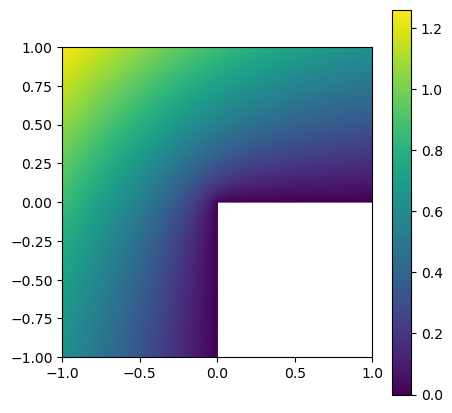

In [8]:
M = Lshape(2,4)
uh, numdofs, L2err, H1err = uniform(M,f,u,u, maxiter=3, draw=False)

0


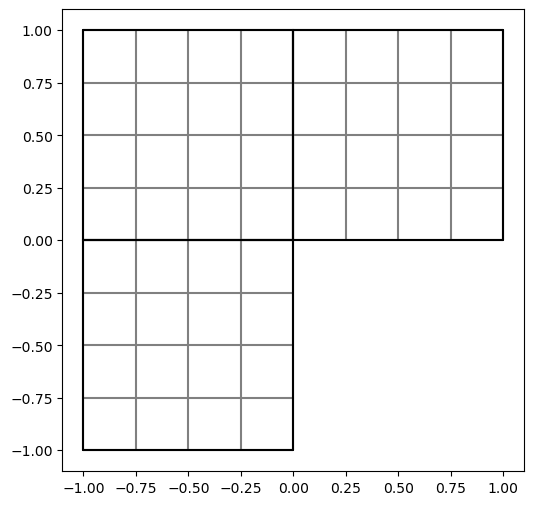

/tmp/ipykernel_3031/1835750879.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Estimate and Marking took 0.03127884864807129 seconds.
Refinement took 0.008725643157958984 seconds.

1


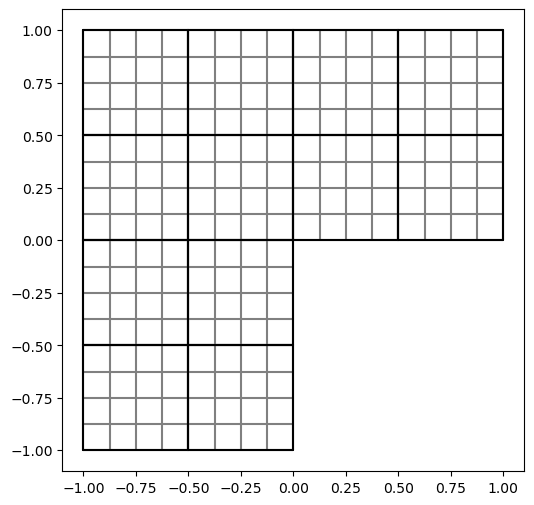

Estimate and Marking took 0.17550373077392578 seconds.
Refinement took 0.010628938674926758 seconds.

2


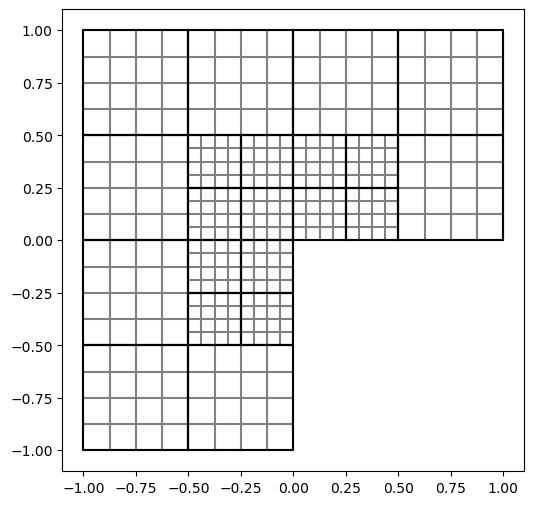

Estimate and Marking took 0.3638181686401367 seconds.
Refinement took 0.012746810913085938 seconds.

3


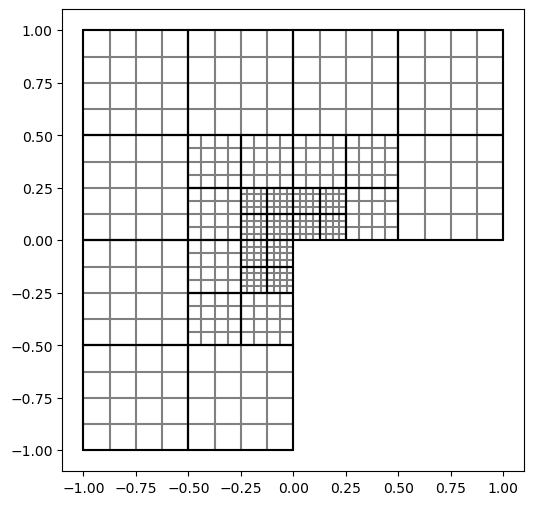

Estimate and Marking took 0.5447783470153809 seconds.
Refinement took 0.014577865600585938 seconds.

4


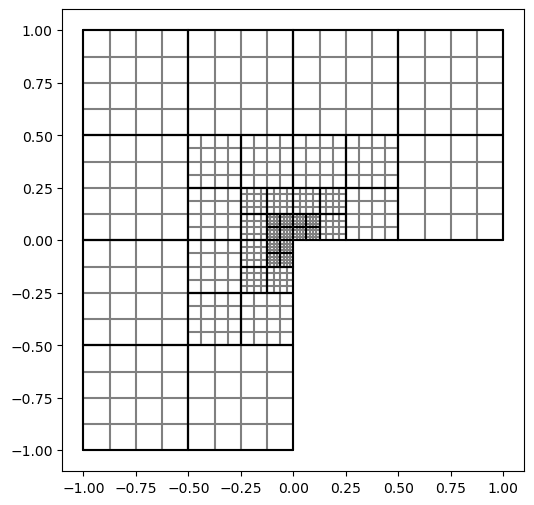

Estimate and Marking took 0.717740535736084 seconds.
Refinement took 0.016144514083862305 seconds.

5


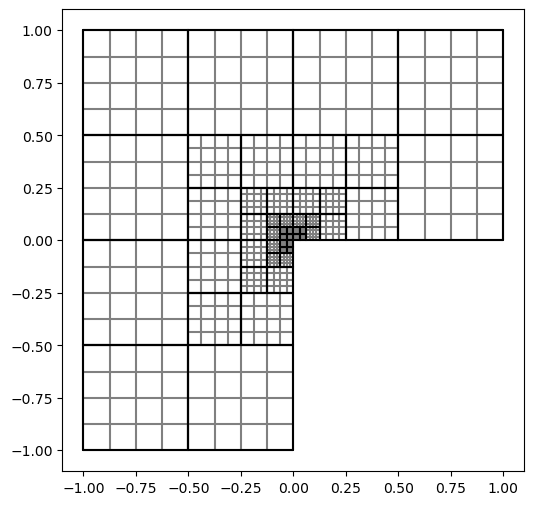

Estimate and Marking took 0.8931705951690674 seconds.
Refinement took 0.037348031997680664 seconds.

6


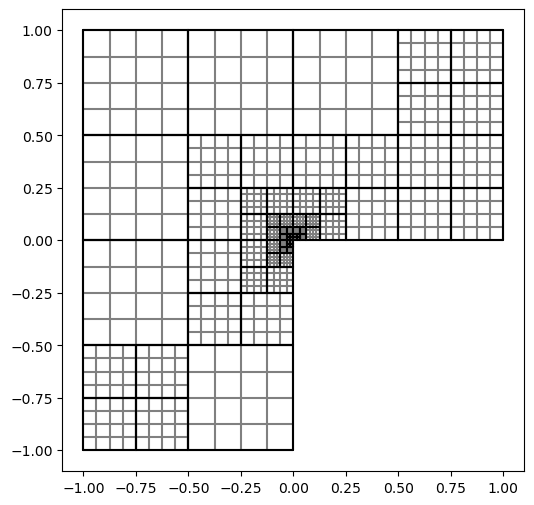

Estimate and Marking took 1.2393608093261719 seconds.
Refinement took 0.05152750015258789 seconds.

7


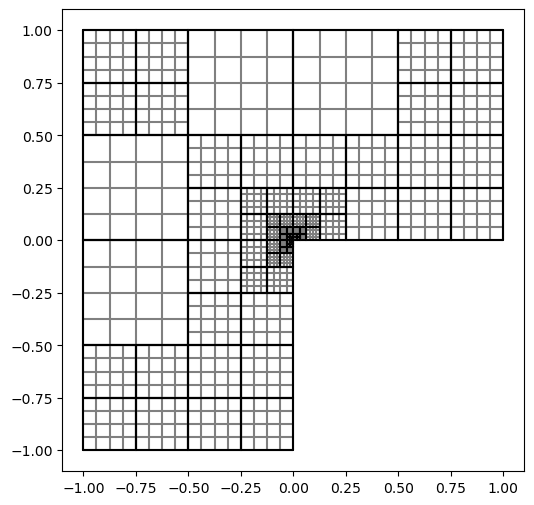

Estimate and Marking took 1.450409173965454 seconds.
Refinement took 0.01575326919555664 seconds.

8


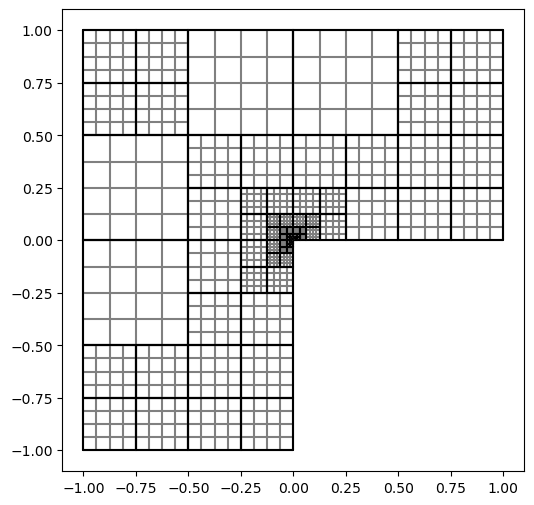

Estimate and Marking took 1.564445972442627 seconds.
Refinement took 0.033948421478271484 seconds.

9


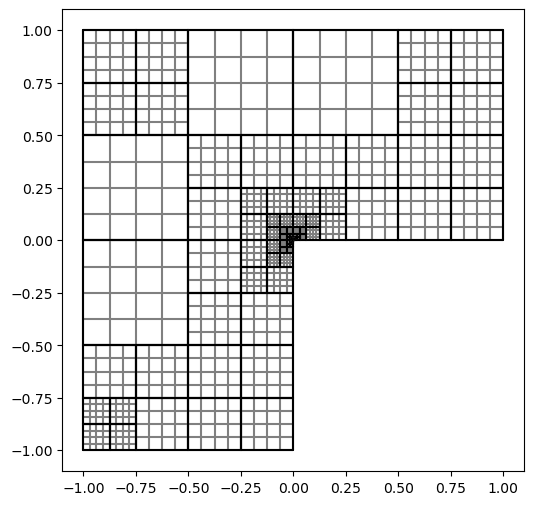

Estimate and Marking took 1.8251078128814697 seconds.
Refinement took 0.056601524353027344 seconds.

10


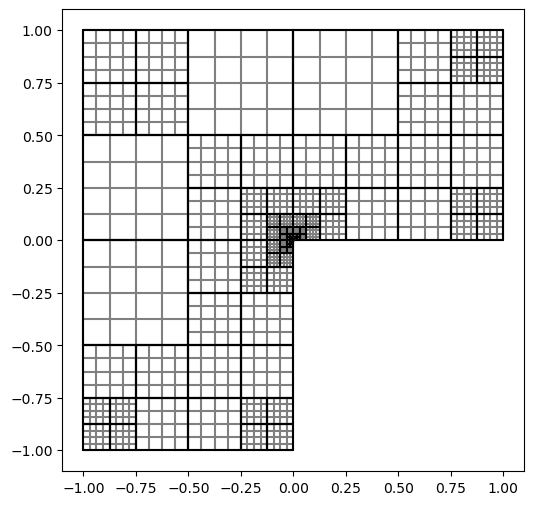

Estimate and Marking took 2.167753219604492 seconds.
Refinement took 0.06491208076477051 seconds.

11


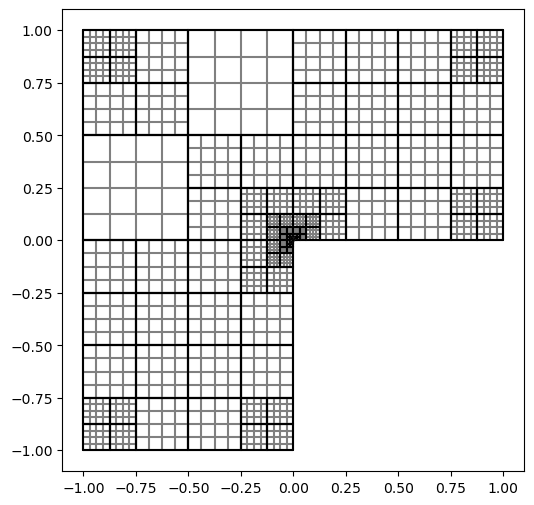

Estimate and Marking took 2.43851637840271 seconds.
Refinement took 0.14764070510864258 seconds.

12


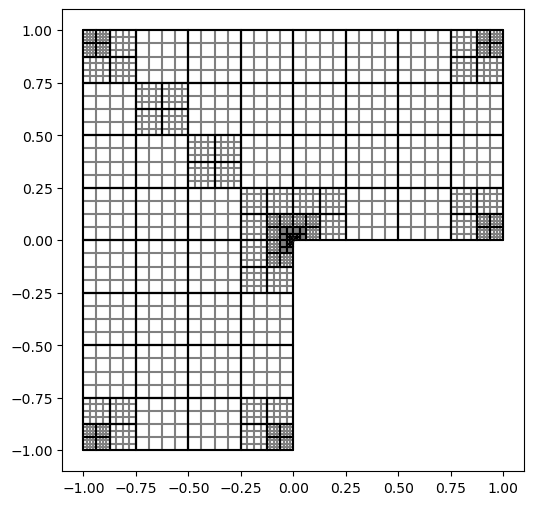

Estimate and Marking took 3.1566033363342285 seconds.
Refinement took 0.31197023391723633 seconds.

13


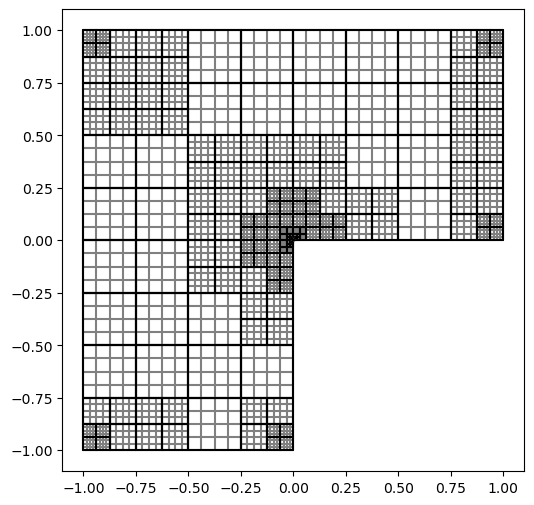

Estimate and Marking took 4.267620325088501 seconds.
Refinement took 0.5060784816741943 seconds.

14


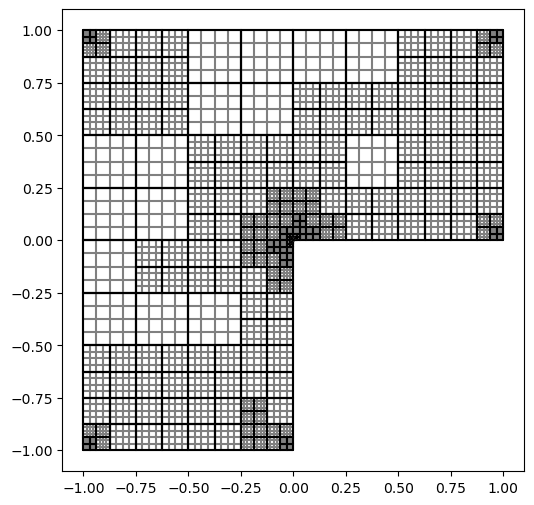

Estimate and Marking took 5.699622392654419 seconds.
Refinement took 0.8580572605133057 seconds.

15


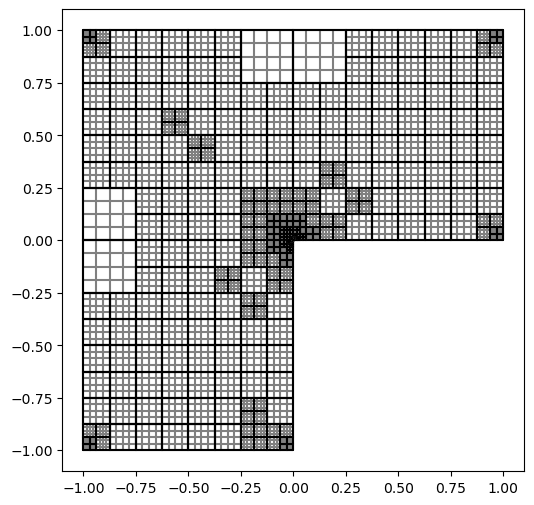

Estimate and Marking took 7.6638829708099365 seconds.
Refinement took 1.3360686302185059 seconds.

16


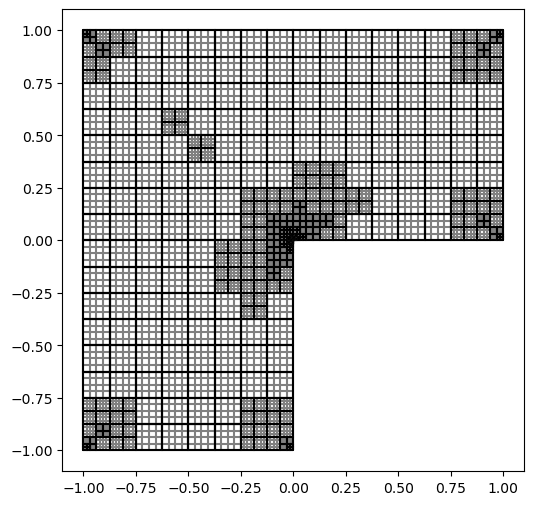

Estimate and Marking took 10.188388109207153 seconds.
Refinement took 2.8883259296417236 seconds.

17


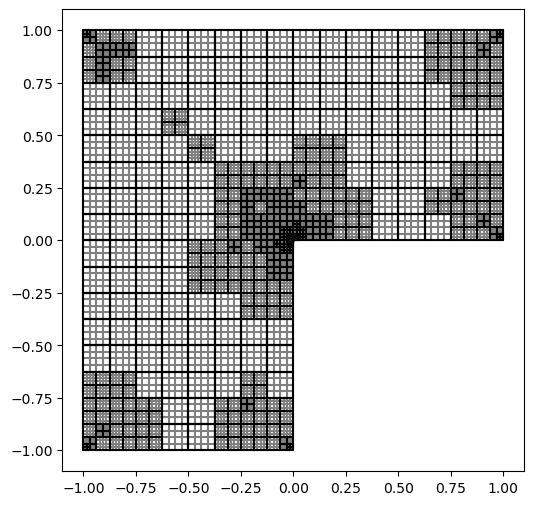

Estimate and Marking took 14.043824434280396 seconds.
Refinement took 6.742763042449951 seconds.

18


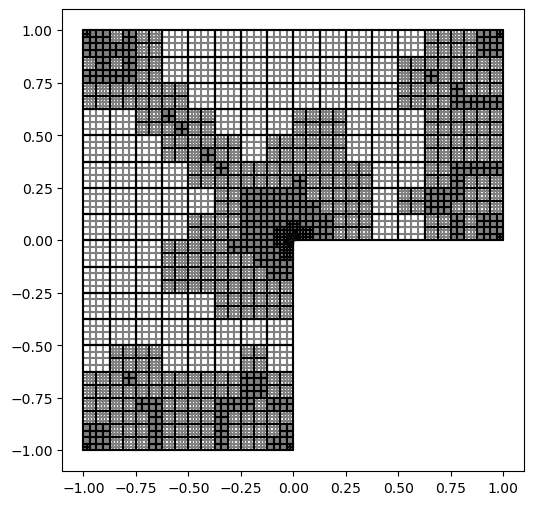

Estimate and Marking took 20.865253925323486 seconds.
Refinement took 11.408227920532227 seconds.

19


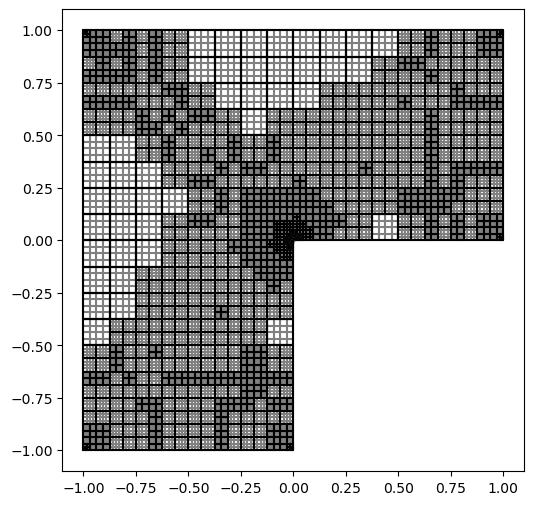

In [10]:
M = Lshape(2,4)
uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f=lambda x,y: 1, g=lambda x,y: 0, draw=True, maxiter=20)

0


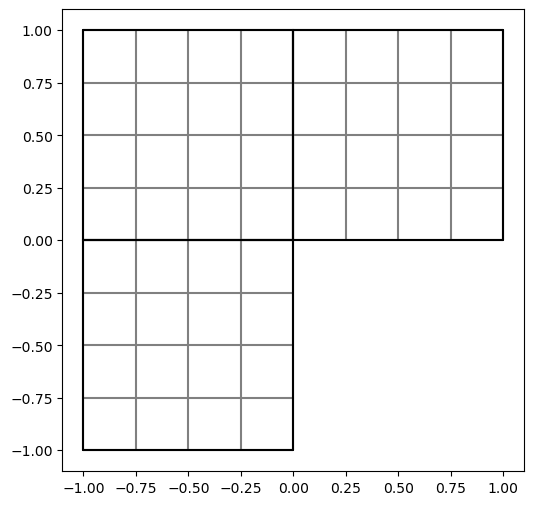

/tmp/ipykernel_3031/1835750879.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Estimate and Marking took 0.030403614044189453 seconds.
Refinement took 0.006470918655395508 seconds.

1


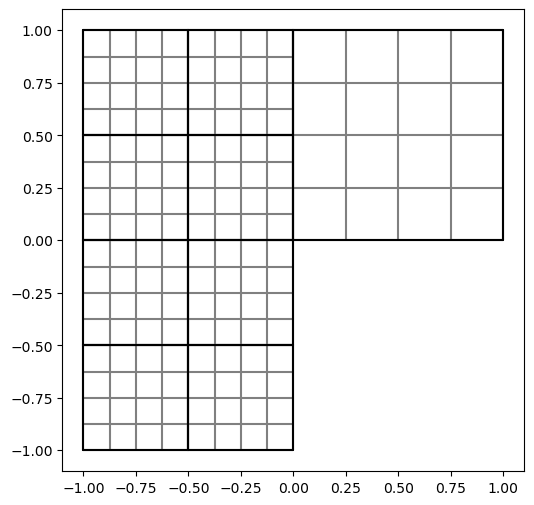

Estimate and Marking took 0.13292527198791504 seconds.
Refinement took 0.006552934646606445 seconds.

2


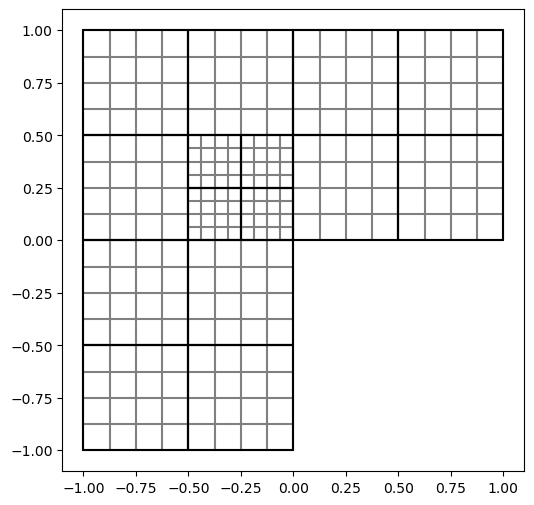

Estimate and Marking took 0.24968242645263672 seconds.
Refinement took 0.011688947677612305 seconds.

3


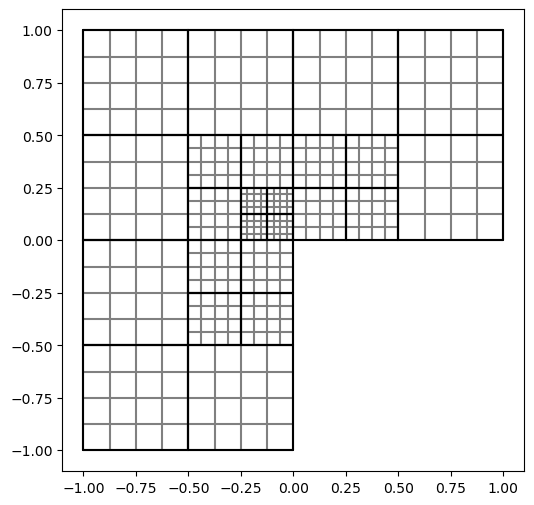

Estimate and Marking took 0.43491530418395996 seconds.
Refinement took 0.013073205947875977 seconds.

4


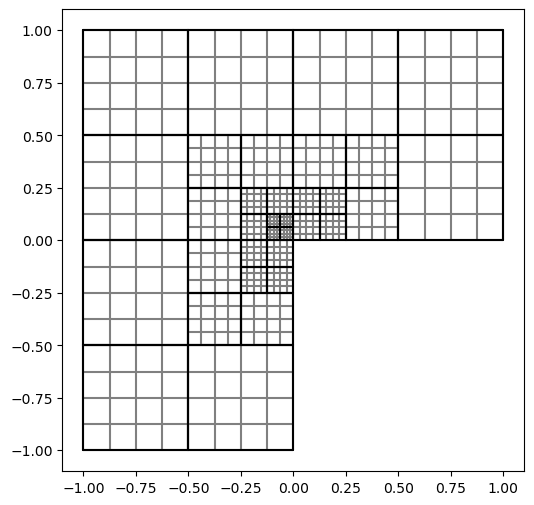

Estimate and Marking took 0.6001813411712646 seconds.
Refinement took 0.014587163925170898 seconds.

5


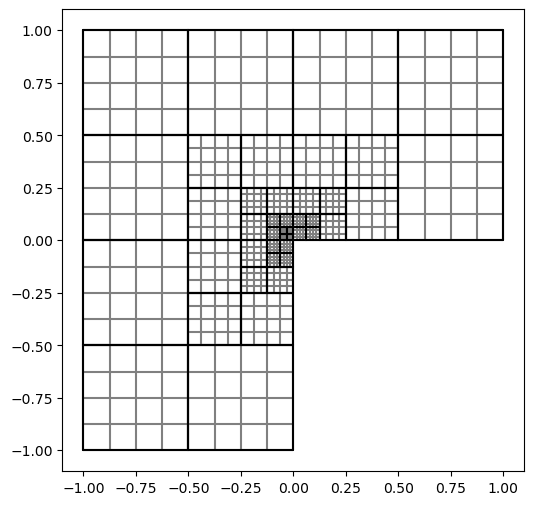

Estimate and Marking took 0.7990868091583252 seconds.
Refinement took 0.022808313369750977 seconds.

6


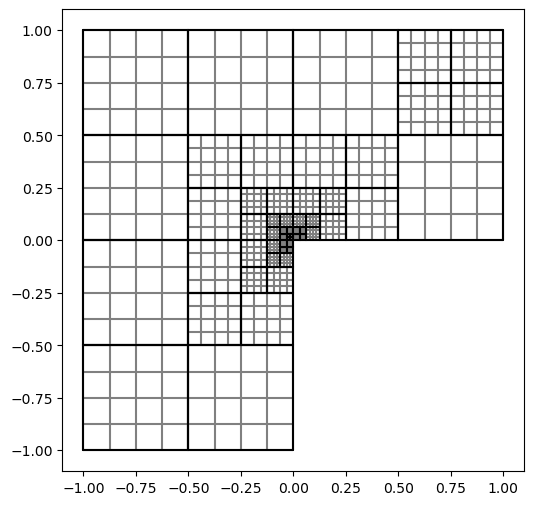

Estimate and Marking took 1.0211355686187744 seconds.
Refinement took 0.04016375541687012 seconds.

7


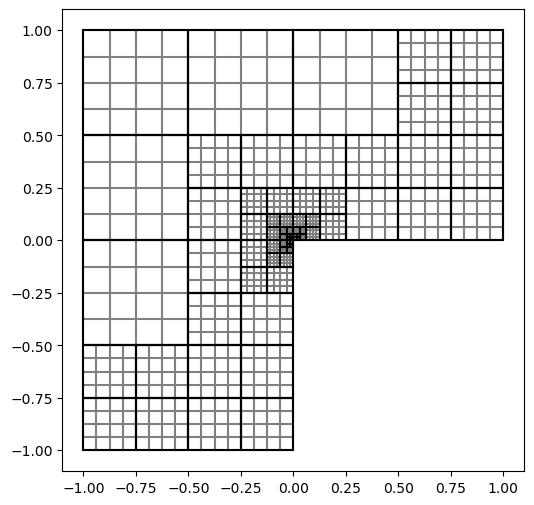

Estimate and Marking took 1.3646183013916016 seconds.
Refinement took 0.022620439529418945 seconds.

8


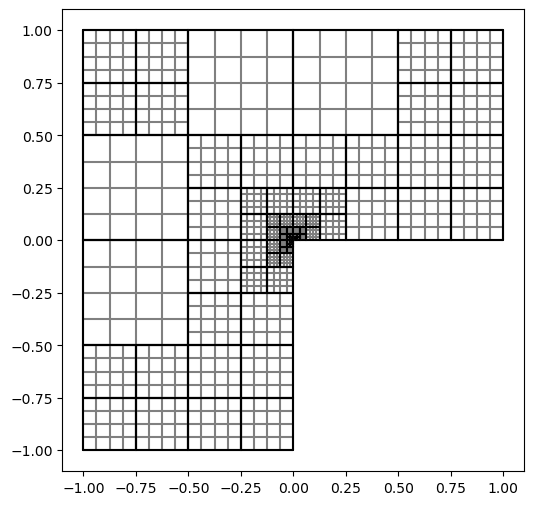

Estimate and Marking took 1.5331740379333496 seconds.
Refinement took 0.024477005004882812 seconds.

9


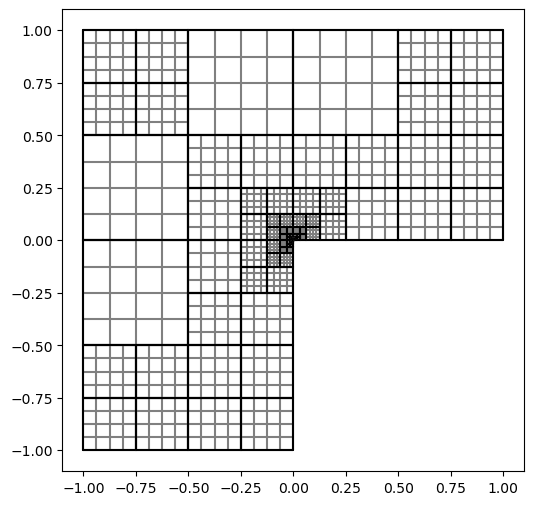

Estimate and Marking took 1.7650861740112305 seconds.
Refinement took 0.04474163055419922 seconds.

10


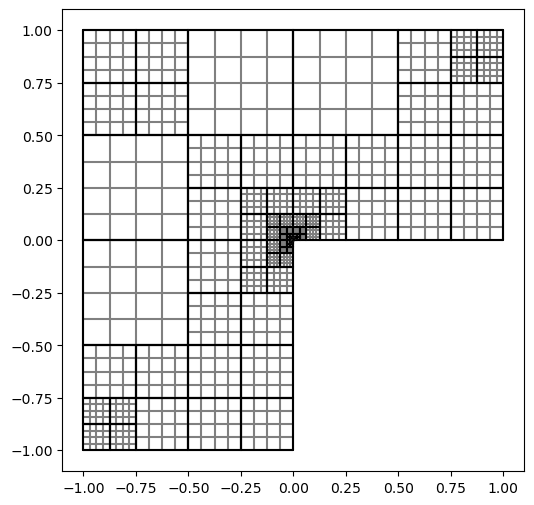

Estimate and Marking took 1.9676461219787598 seconds.
Refinement took 0.050351619720458984 seconds.

11


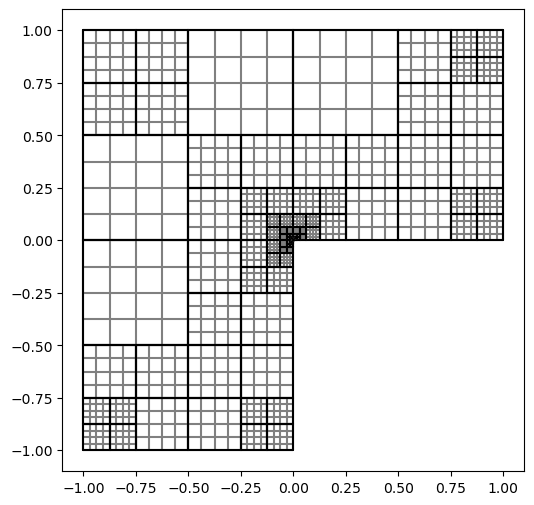

Estimate and Marking took 2.281250476837158 seconds.
Refinement took 0.04392409324645996 seconds.

12


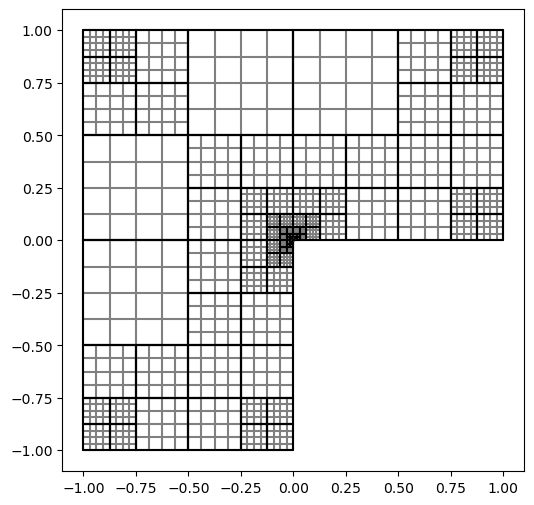

Estimate and Marking took 2.569821834564209 seconds.
Refinement took 0.09684395790100098 seconds.

13


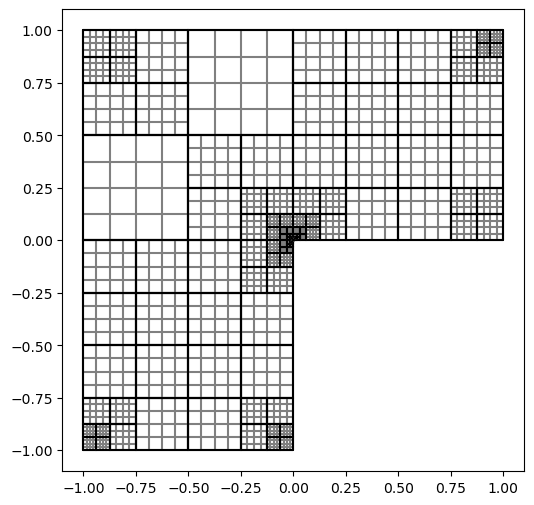

Estimate and Marking took 2.9460909366607666 seconds.
Refinement took 0.09758353233337402 seconds.

14


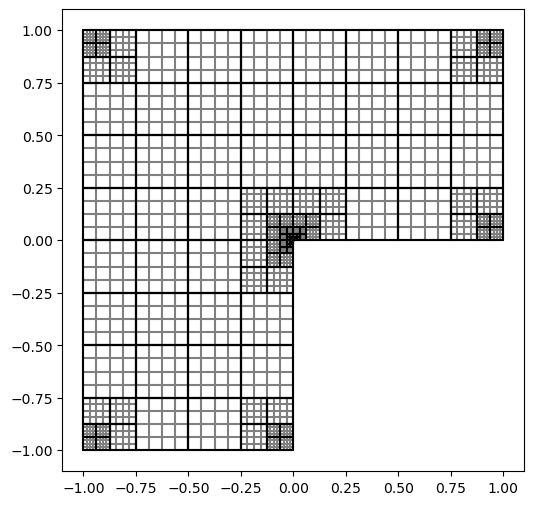

Estimate and Marking took 3.376207113265991 seconds.
Refinement took 0.2760179042816162 seconds.

15


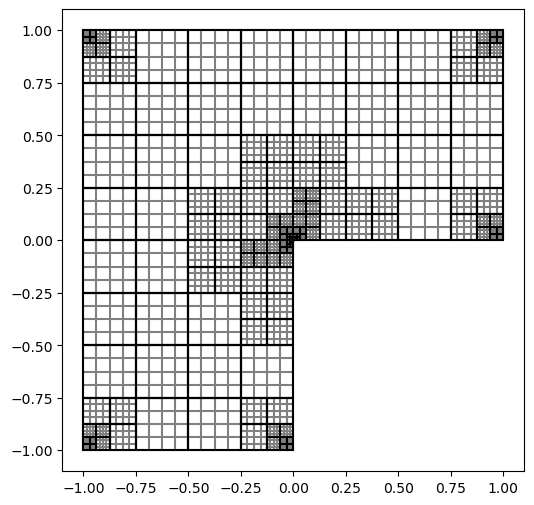

Estimate and Marking took 4.257517576217651 seconds.
Refinement took 0.45113658905029297 seconds.

16


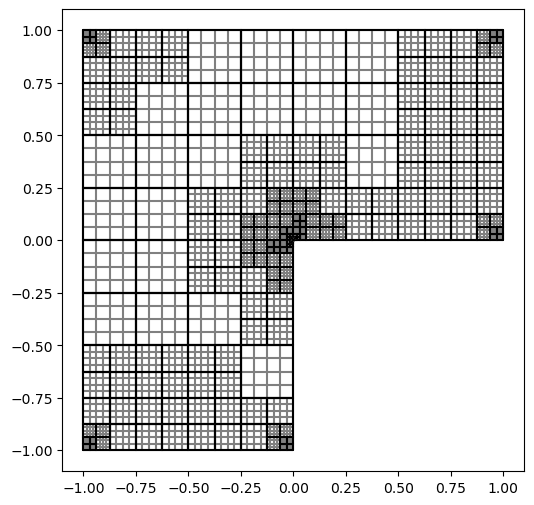

Estimate and Marking took 5.587620496749878 seconds.
Refinement took 0.46344447135925293 seconds.

17


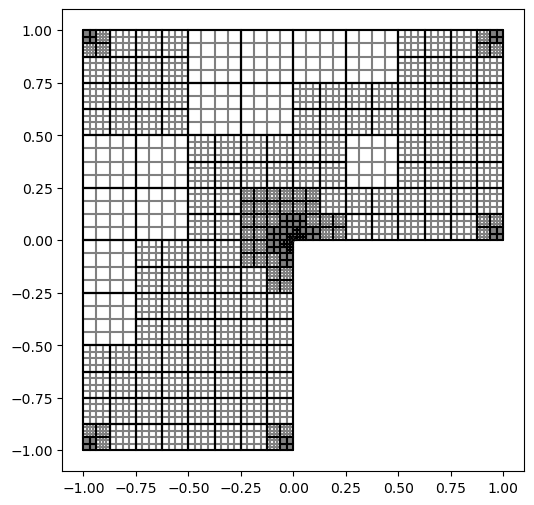

Estimate and Marking took 6.715324401855469 seconds.
Refinement took 0.8367524147033691 seconds.

18


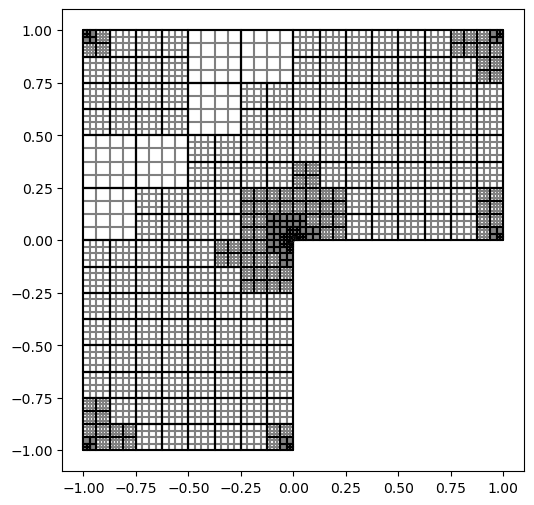

Estimate and Marking took 8.372722625732422 seconds.
Refinement took 1.3960363864898682 seconds.

19


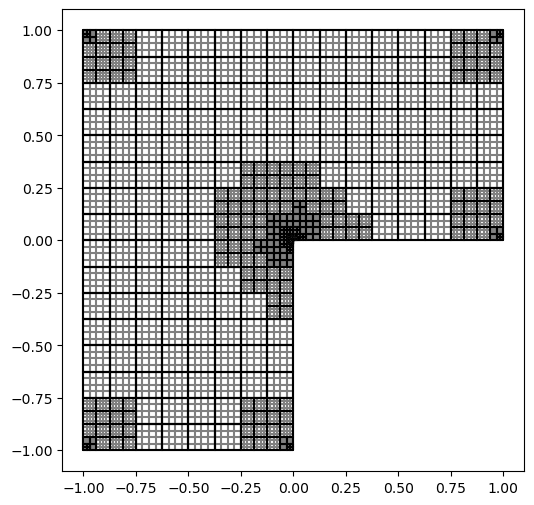

Estimate and Marking took 10.712458372116089 seconds.
Refinement took 2.842698812484741 seconds.

20


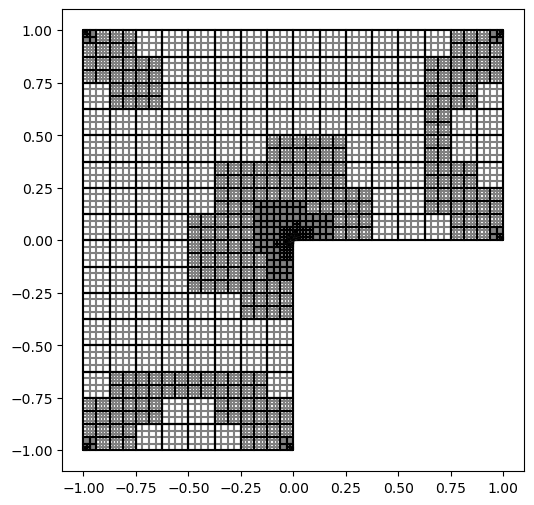

Estimate and Marking took 14.515727043151855 seconds.
Refinement took 4.388341426849365 seconds.

21


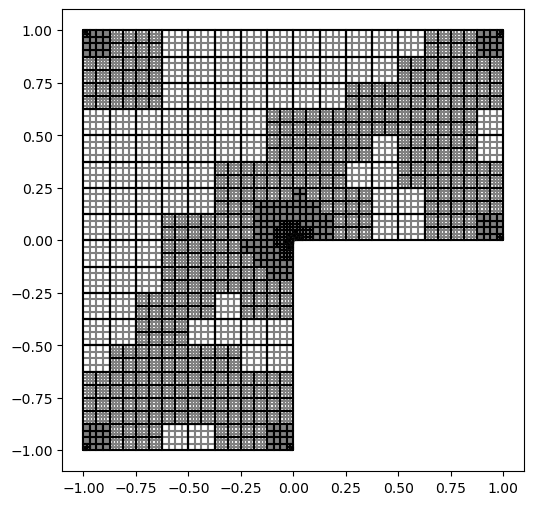

Estimate and Marking took 19.165518283843994 seconds.
Refinement took 6.90997052192688 seconds.

22


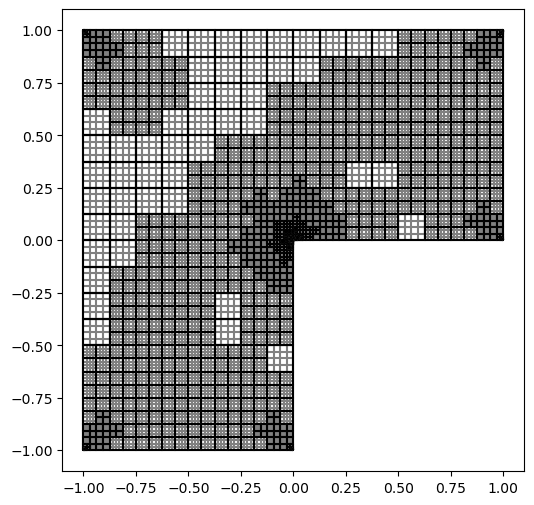

Estimate and Marking took 24.910081386566162 seconds.
Refinement took 12.892460823059082 seconds.

23


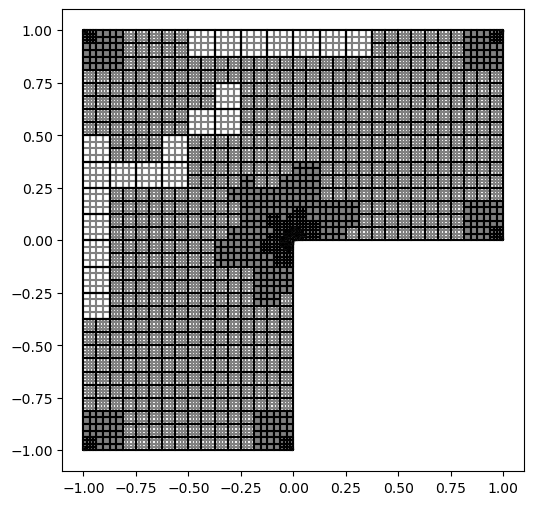

Estimate and Marking took 32.52197599411011 seconds.
Refinement took 23.277578592300415 seconds.

24


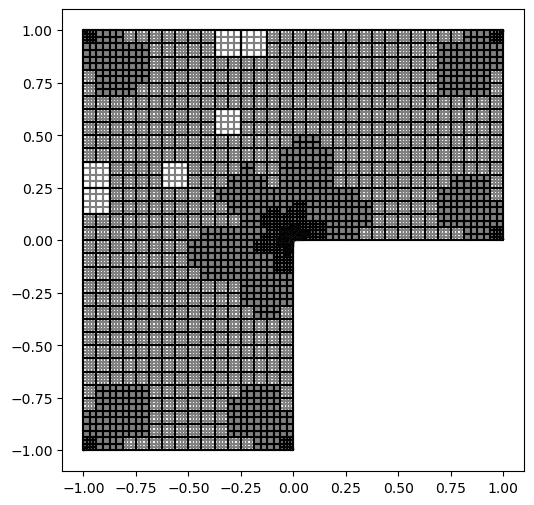

In [13]:
M = Lshape(3,4)
uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f=lambda x,y: 1, g=lambda x,y: 0, draw=True, maxiter=25)

0


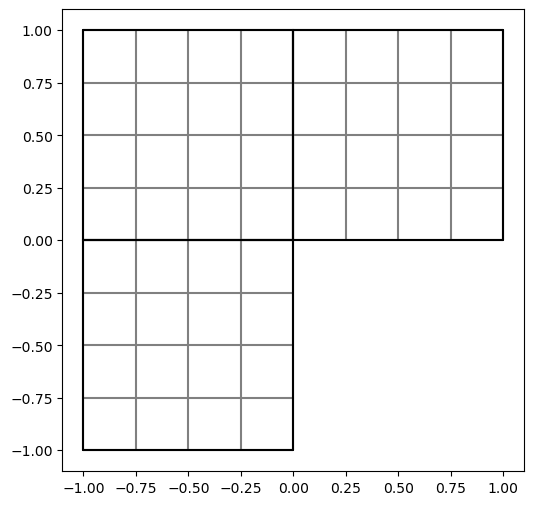

/tmp/ipykernel_3031/1835750879.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Estimate and Marking took 0.031372785568237305 seconds.
Refinement took 0.007184505462646484 seconds.

1


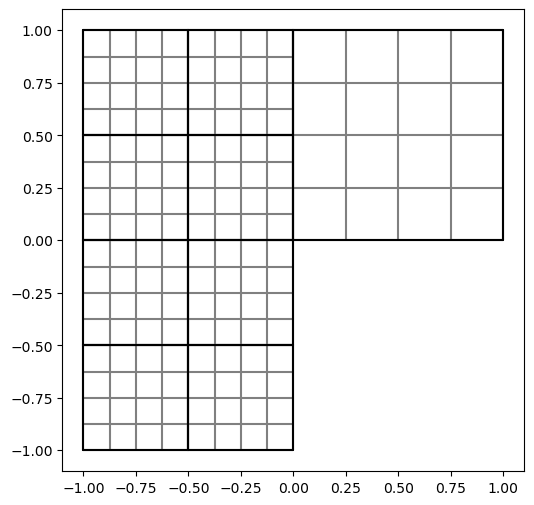

Estimate and Marking took 0.13404202461242676 seconds.
Refinement took 0.0065991878509521484 seconds.

2


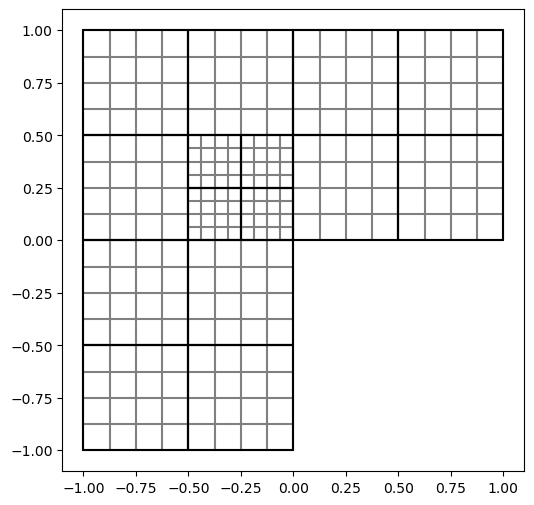

Estimate and Marking took 0.24773716926574707 seconds.
Refinement took 0.0073528289794921875 seconds.

3


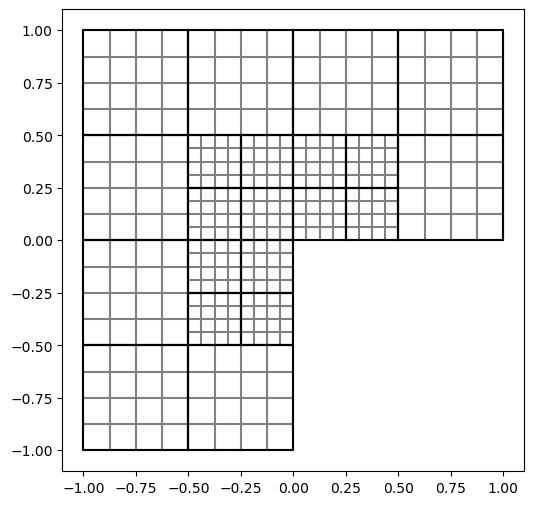

Estimate and Marking took 0.3537633419036865 seconds.
Refinement took 0.008148431777954102 seconds.

4


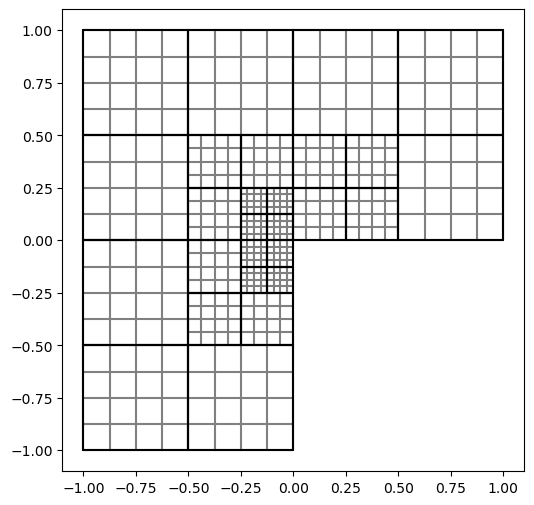

Estimate and Marking took 0.4723341464996338 seconds.
Refinement took 0.008995771408081055 seconds.

5


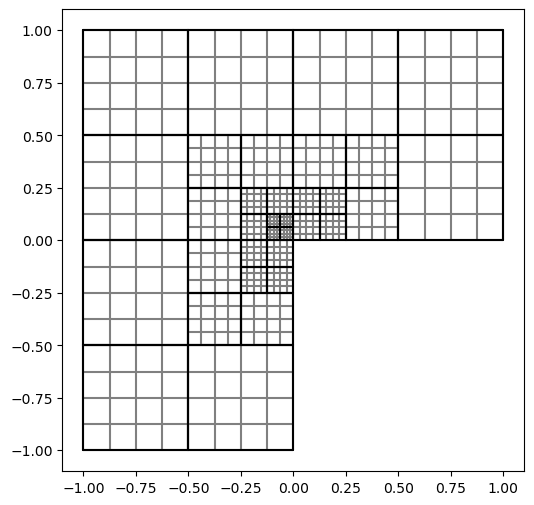

Estimate and Marking took 0.598625898361206 seconds.
Refinement took 0.009803295135498047 seconds.

6


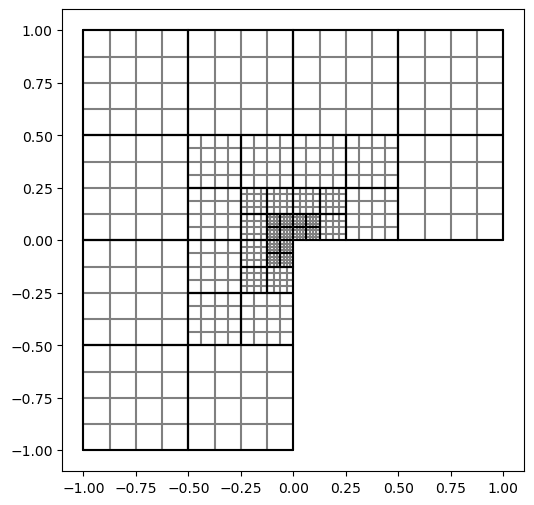

Estimate and Marking took 0.7111623287200928 seconds.
Refinement took 0.01589488983154297 seconds.

7


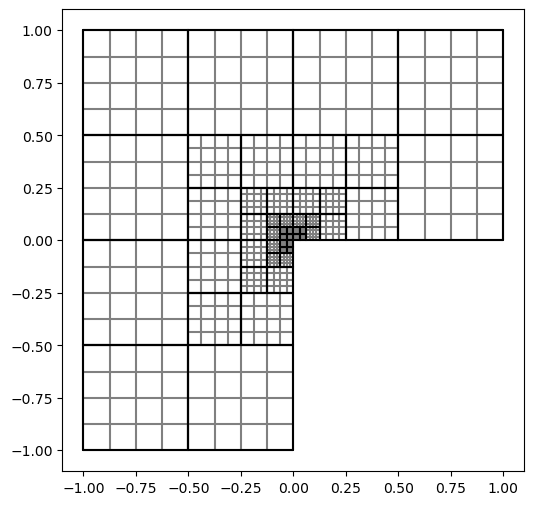

Estimate and Marking took 0.8776328563690186 seconds.
Refinement took 0.01796889305114746 seconds.

8


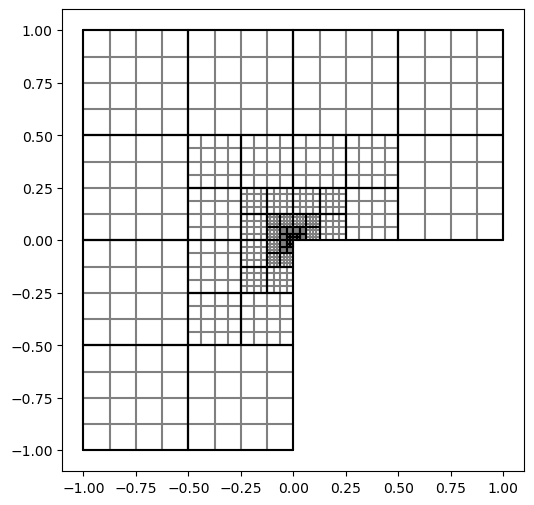

Estimate and Marking took 1.0522480010986328 seconds.
Refinement took 0.019556760787963867 seconds.

9


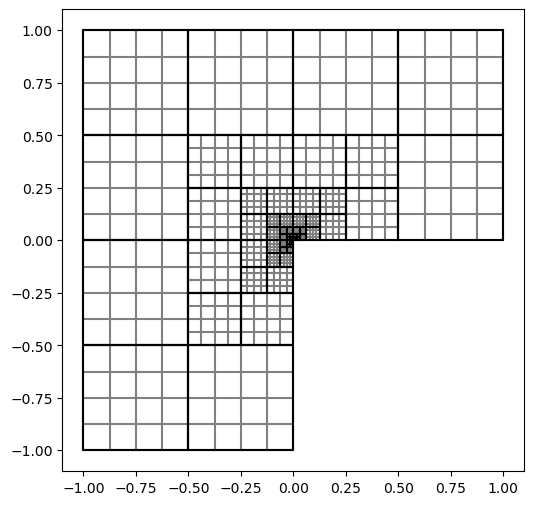

Estimate and Marking took 1.2320926189422607 seconds.
Refinement took 0.03656649589538574 seconds.

10


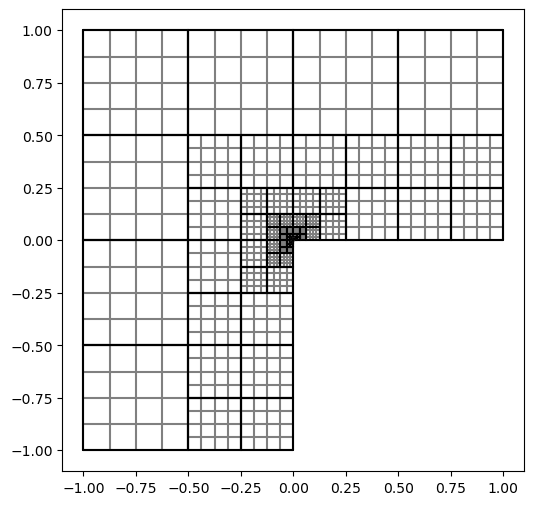

Estimate and Marking took 1.5406379699707031 seconds.
Refinement took 0.0412592887878418 seconds.

11


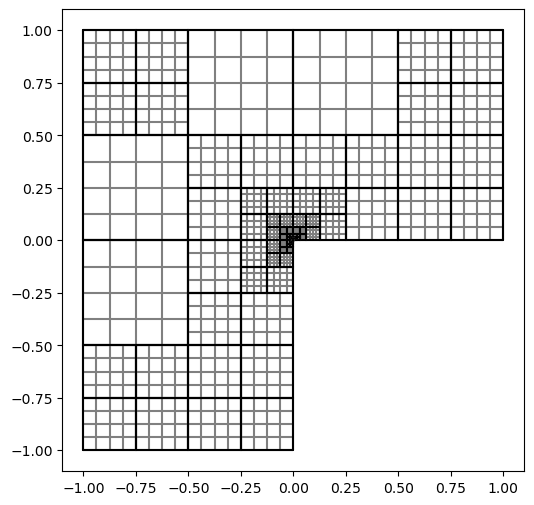

Estimate and Marking took 1.7743964195251465 seconds.
Refinement took 0.027322053909301758 seconds.

12


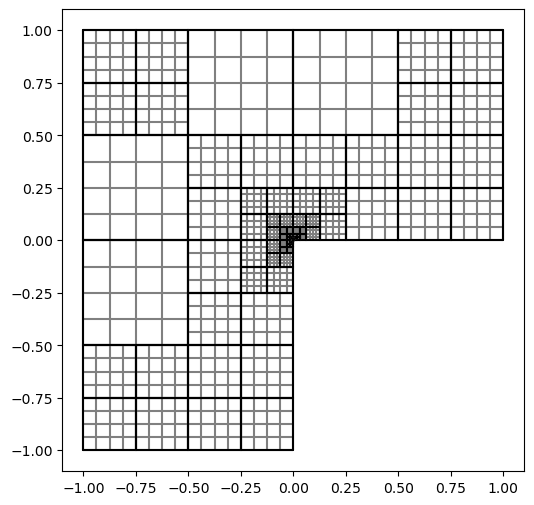

Estimate and Marking took 1.9471287727355957 seconds.
Refinement took 0.049299001693725586 seconds.

13


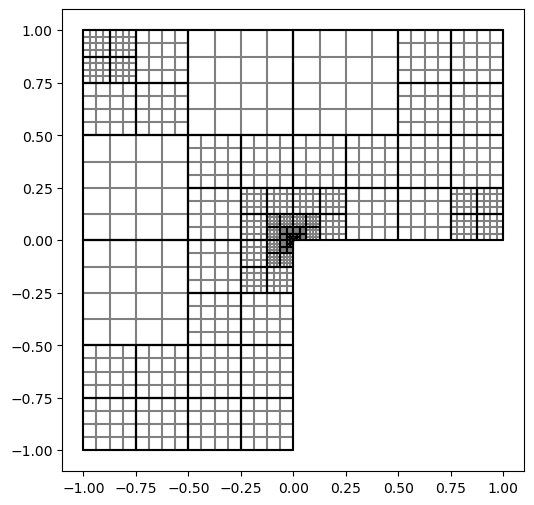

Estimate and Marking took 2.2448081970214844 seconds.
Refinement took 0.055319786071777344 seconds.

14


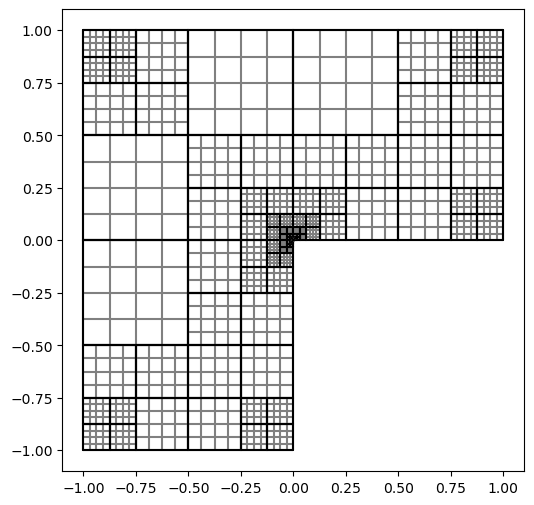

Estimate and Marking took 2.5769753456115723 seconds.
Refinement took 0.036032676696777344 seconds.

15


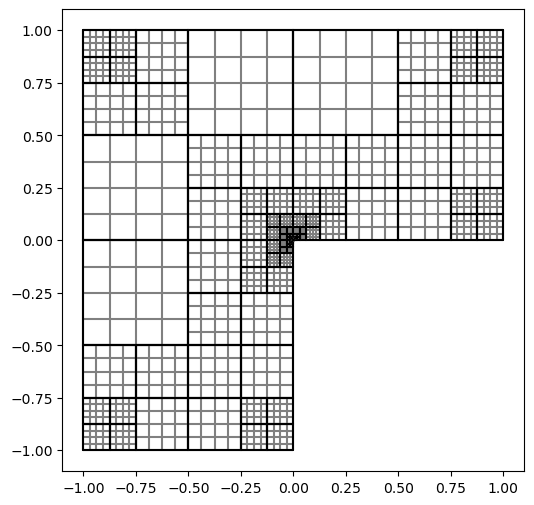

Estimate and Marking took 2.7022640705108643 seconds.
Refinement took 0.06303858757019043 seconds.

16


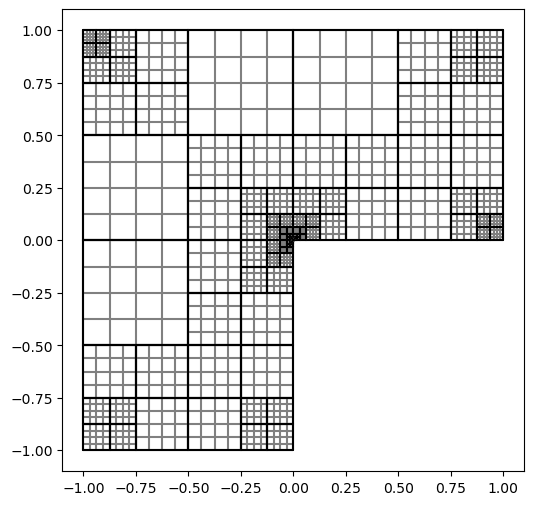

Estimate and Marking took 2.990870237350464 seconds.
Refinement took 0.06902599334716797 seconds.

17


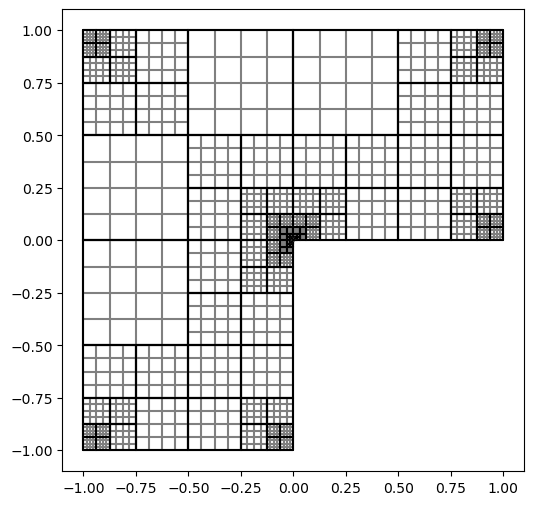

Estimate and Marking took 3.29423451423645 seconds.
Refinement took 0.04362010955810547 seconds.

18


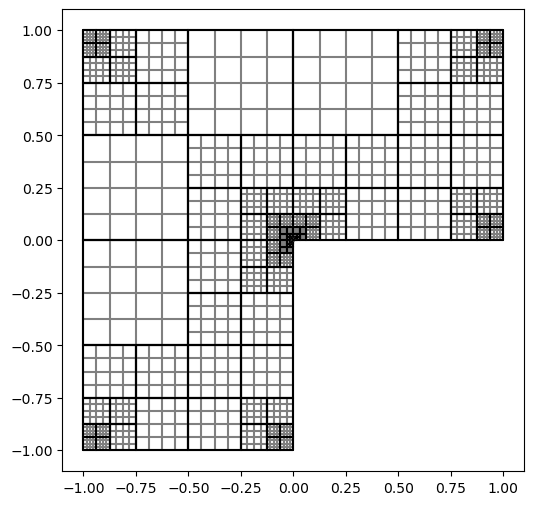

Estimate and Marking took 3.5166659355163574 seconds.
Refinement took 0.04618406295776367 seconds.

19


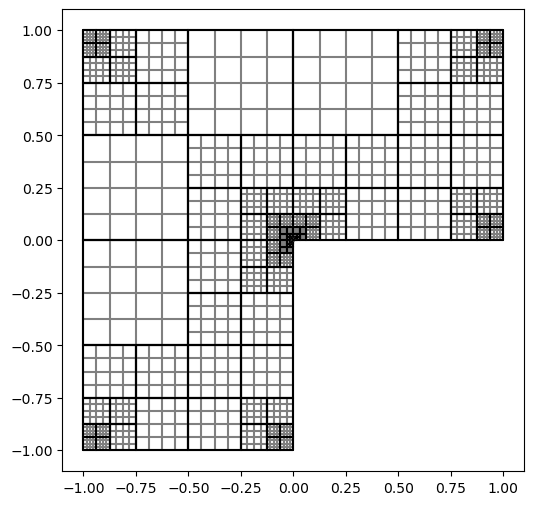

Estimate and Marking took 3.637608051300049 seconds.
Refinement took 0.0810098648071289 seconds.

20


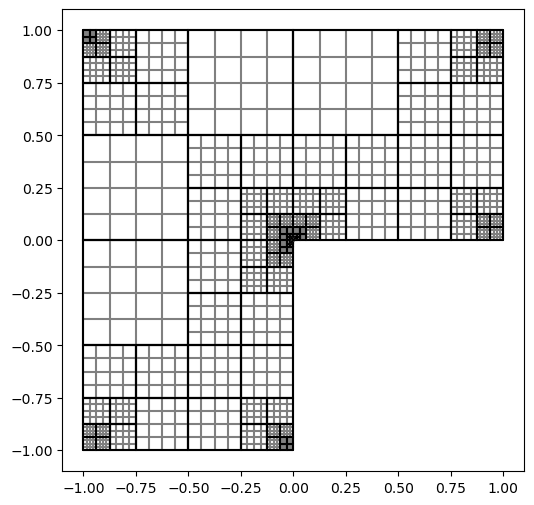

Estimate and Marking took 4.03377890586853 seconds.
Refinement took 0.08563923835754395 seconds.

21


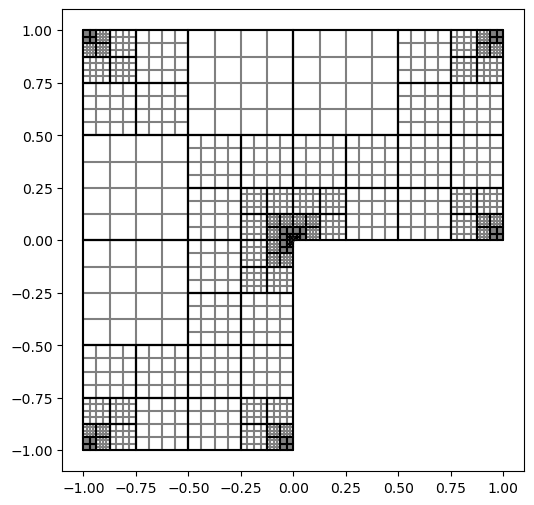

Estimate and Marking took 4.1983418464660645 seconds.
Refinement took 0.0723268985748291 seconds.

22


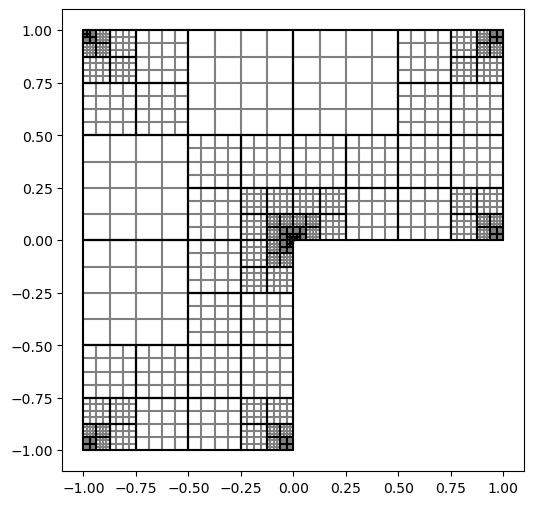

Estimate and Marking took 4.427340745925903 seconds.
Refinement took 0.1151418685913086 seconds.

23


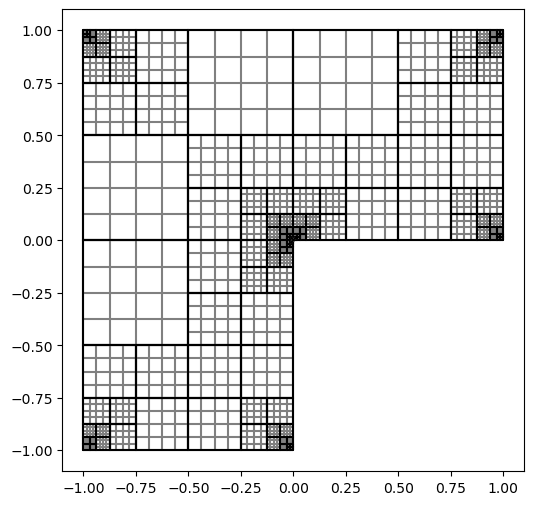

Estimate and Marking took 4.8724517822265625 seconds.
Refinement took 0.14322686195373535 seconds.

24


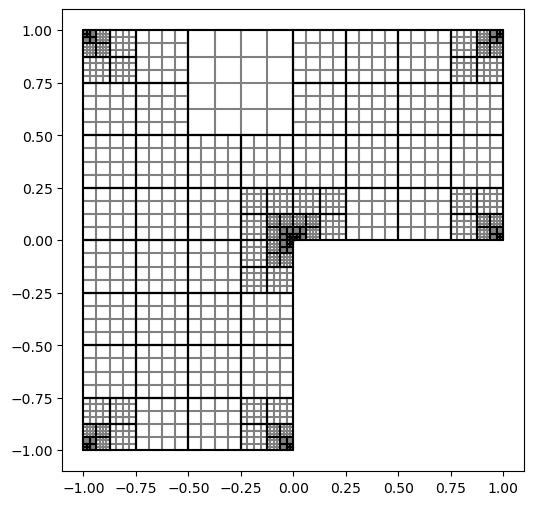

Estimate and Marking took 5.118907928466797 seconds.
Refinement took 0.2943131923675537 seconds.

25


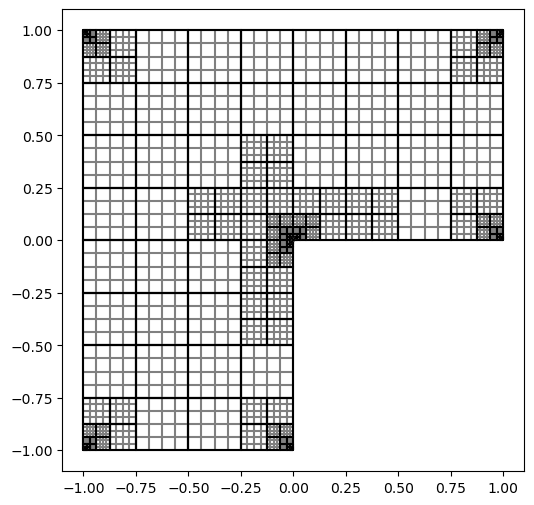

Estimate and Marking took 5.831329584121704 seconds.
Refinement took 0.2985086441040039 seconds.

26


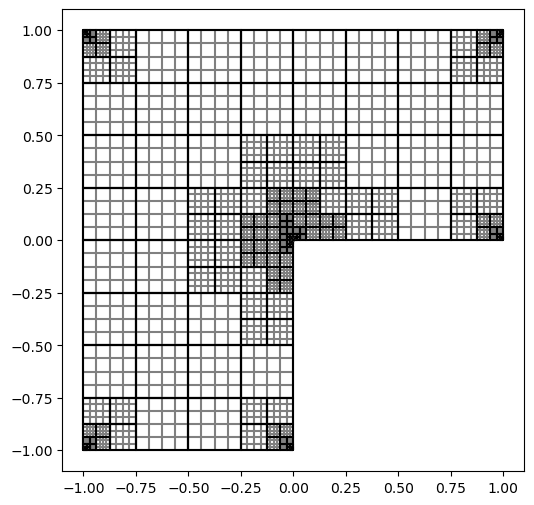

Estimate and Marking took 6.5564305782318115 seconds.
Refinement took 0.5846970081329346 seconds.

27


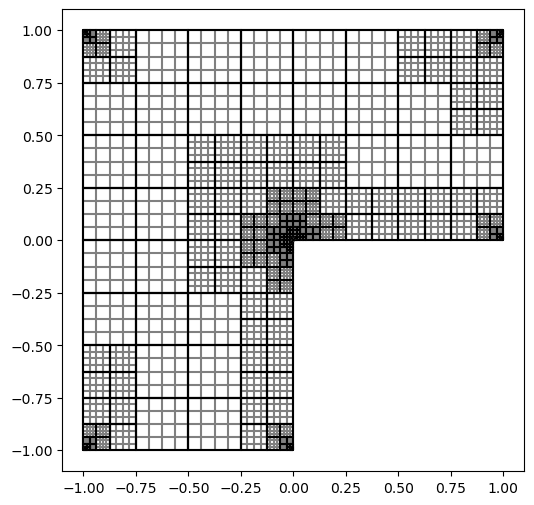

Estimate and Marking took 7.680792570114136 seconds.
Refinement took 0.5283079147338867 seconds.

28


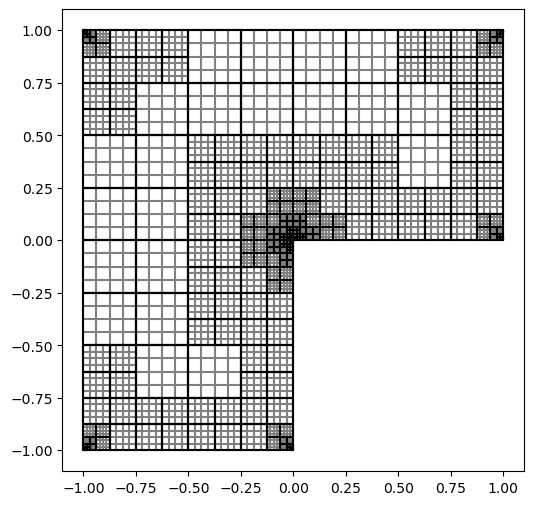

Estimate and Marking took 8.872482299804688 seconds.
Refinement took 0.923764705657959 seconds.

29


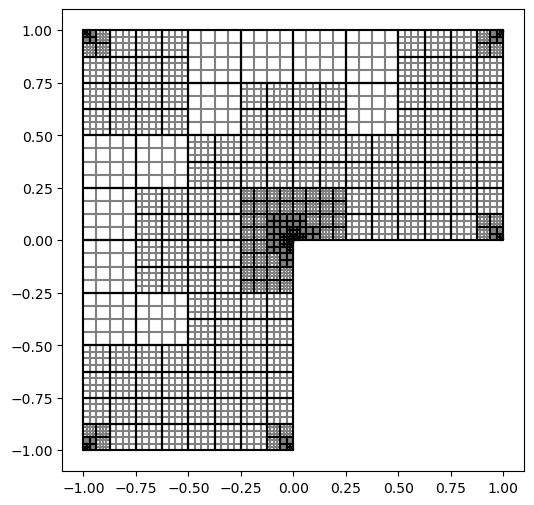

Estimate and Marking took 9.988305568695068 seconds.
Refinement took 1.283031702041626 seconds.

30


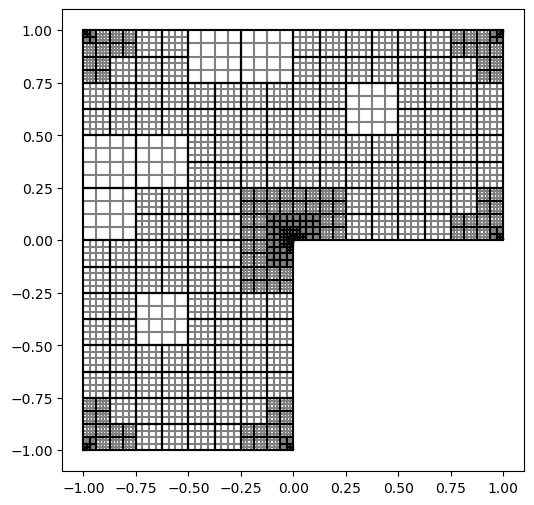

Estimate and Marking took 11.788387537002563 seconds.
Refinement took 1.5942833423614502 seconds.

31


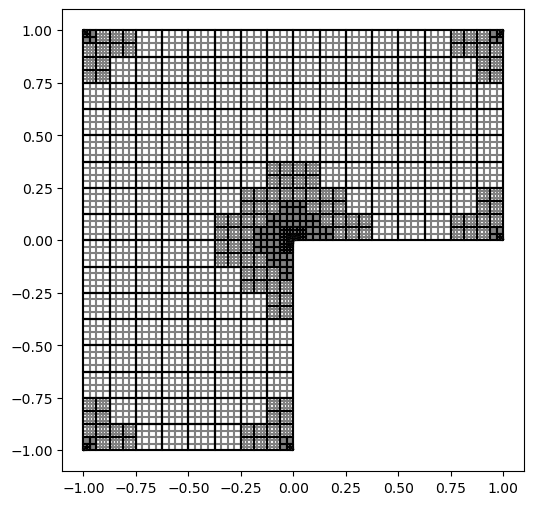

Estimate and Marking took 13.801725625991821 seconds.
Refinement took 2.4630932807922363 seconds.

32


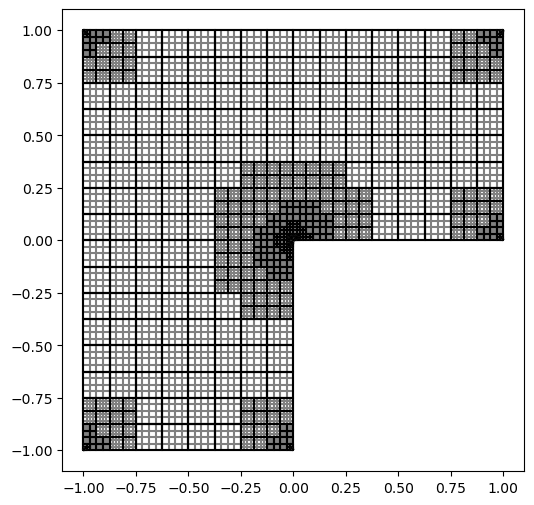

Estimate and Marking took 16.31822657585144 seconds.
Refinement took 3.3410160541534424 seconds.

33


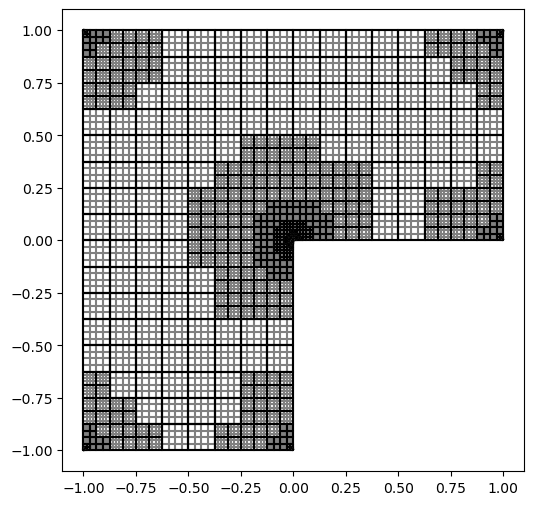

Estimate and Marking took 19.334495067596436 seconds.
Refinement took 5.735081434249878 seconds.

34


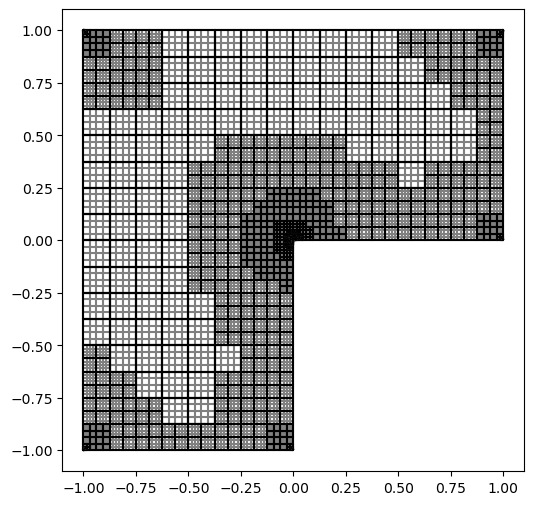

In [15]:
M = Lshape(4,4)
uh_a, numdofs_a, L2err_a, H1err_a, err_est = adaptive(M, f=lambda x,y: 1, g=lambda x,y: 0, draw=True, maxiter=35)

In [31]:
H1err_a

array([3.45957e-02, 2.16966e-02, 1.36461e-02, 8.59241e-03, 5.41380e-03, 3.41370e-03, 2.15598e-03, 1.36692e-03, 8.74819e-04, 5.72280e-04, 3.92116e-04, 2.60957e-04, 1.67543e-04, 1.03929e-04, 6.78697e-05, 4.37581e-05, 2.89581e-05, 1.78560e-05, 1.15298e-05, 7.81347e-06])

In [32]:
numdofs

array([9.60000e+01, 2.80000e+02, 9.36000e+02, 3.40000e+03, 1.29360e+04, 5.04400e+04, 1.99176e+05])

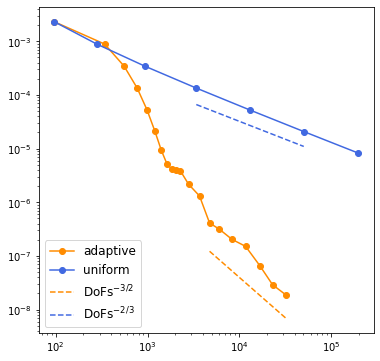

In [33]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs_a, L2err_a, 'o-',color='darkorange')
plt.loglog(numdofs, L2err, 'o-',color='royalblue')
plt.loglog(numdofs_a[13:20],[0.04/n**(3/2) for n in numdofs_a[13:20]],linestyle='--',color='darkorange')
plt.loglog(numdofs[3:6],[0.015/n**(2/3) for n in numdofs[3:6]],linestyle='--',color='royalblue')
plt.legend(['adaptive','uniform','DoFs$^{-3/2}$','DoFs$^{-2/3}$'],loc='lower left',prop={'size': 12})
plt.show()

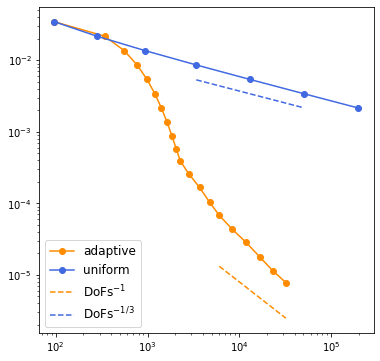

In [34]:
plt.figure(figsize=(6,6))
plt.loglog(numdofs_a, H1err_a, 'o-',color='darkorange')
plt.loglog(numdofs, H1err, 'o-',color='royalblue')
plt.loglog(numdofs_a[14:20],[0.08/n**(1) for n in numdofs_a[14:20]],linestyle='--',color='darkorange')
plt.loglog(numdofs[3:6],[0.08/n**(1/3) for n in numdofs[3:6]],linestyle='--',color='royalblue')
plt.legend(['adaptive','uniform','DoFs$^{-1}$','DoFs$^{-1/3}$'],loc='lower left',prop={'size': 12})
plt.show()

In [22]:
M=Fichera(2,5)

In [9]:
u=lambda x,y,z: sin(pi/2*(x+1))*sin(pi/2*(y+1))*sin(pi/2*(z+1))+x*y*z+1
f=lambda x,y,z: 3*(pi/2)**2*sin(pi/2*(x+1))*sin(pi/2*(y+1))*sin(pi/2*(z+1))

In [10]:
uh, numdofs,L2err, H1err = uniform(M,f,u,maxiter=5,dim=3)

0


/tmp/ipykernel_3183/1670932861.py:113: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Refinement took 0.00046944618225097656 seconds.
1
Refinement took 0.001295328140258789 seconds.
2
Refinement took 0.0004355907440185547 seconds.
3
Refinement took 0.00047278404235839844 seconds.
4


In [31]:
MP=AMultipatch(M,automatch=True,dim=3)

In [93]:
# geos=[geometry.unit_cube()]
# kvs=(3*(bspline.make_knots(2,0,1,4),),)
# patches=[(k,g) for k,g in zip(kvs,geos)]
# M=PatchMesh3D(patches)
# M.split_patch(0);
#M.draw(knots=False, patch_idx=True)
M=Fichera(2,5)

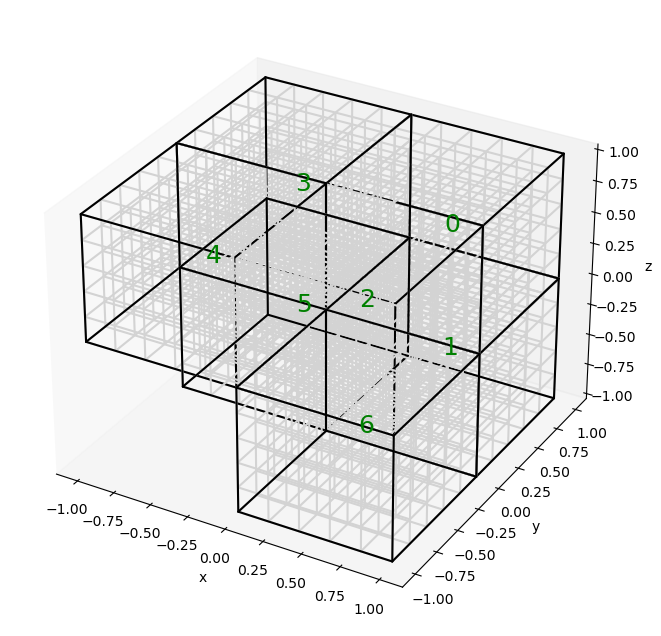

In [74]:
M.draw(patch_idx=True)

In [94]:
u=lambda x,y,z: sin(pi*x)*sin(pi*y)*sin(pi*z)
f=lambda x,y,z: 3*(pi)**2*sin(pi*x)*sin(pi*y)*sin(pi*z)

In [95]:
M.split_patches({4:None,3:None})

({4: (4, 7, 8, 9, 10, 11, 12, 13), 3: (3, 14, 15, 16, 17, 18, 19, 20)},
 {4: (KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2),
   KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2),
   KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2)),
  3: (KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2),
   KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2),
   KnotVector(array([0. , 0. , 0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. ]), 2))})

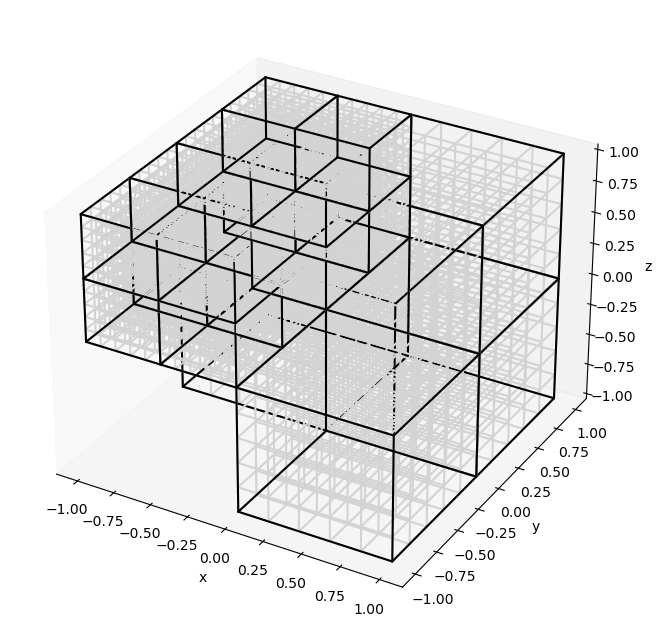

In [77]:
M.draw()

In [96]:
MP=AMultipatch(M,automatch=True, dim=3)

{}


In [88]:
MP.Basis

(<7203x5259 sparse matrix of type '<class 'numpy.float64'>'
 	with 8867 stored elements in Compressed Sparse Row format>,
 <2205x7203 sparse matrix of type '<class 'numpy.float64'>'
 	with 314 stored elements in Compressed Sparse Row format>,
 array([ 147,  740,  741,  747,  748,  754,  755,  761,  762,  768,  769,  775,  776,  782, 1378, 1385, 1392, 1399, 1406, 1413, 1414, 1426, 1433, 1434, 1440, 1441, 1447, 1448, 1454, 1455, 1461, 1462, 1468, 1469, 1666, 1667, 1911, 1918, 1925, 1932, 1939, 1946, 1959, 1967, 1974, 1981, 1988, 1995, 2002, 2063, 2064, 2070, 2071, 2077, 2078, 2084, 2085, 2091, 2092, 2098, 2099, 2101, 2102, 2103, 2104, 2105, 2199, 2200, 2201, 2202, 2203]))

In [91]:
print(MP.Basis[1][741])

  (0, 2701)	-1.0
  (0, 104)	0.12499999999999993
  (0, 153)	0.7499999999999998
  (0, 202)	0.12500000000000017


In [37]:
dim=3
bcs = MP.compute_dirichlet_bcs({0:u})
        #print(bcs)

        # assemble the linear system
Kh, F = MP.assemble_system(vform.stiffness_vf(dim), vform.L2functional_vf(dim, physical=True), f=f)
Mh, u_rhs = MP.assemble_system(vform.mass_vf(dim), vform.L2functional_vf(dim, physical=True), f=u)

        #eliminate boundary conditions
LS = Ass.RestrictedLinearSystem(Kh, F, bcs)
        #solve system and L2 project exact solution into discrete space
uh = LS.complete((cholesky(LS.A))(LS.b))
u_ = (cholesky(Mh))(u_rhs)

IndexError: index (4452) out of range

In [30]:
(u_-uh)@Mh@(u_-uh)

3.523346932343426e-05

In [210]:
PoissonEstimator(MP,f,uh)

array([ 3.2434 ,  3.2434 , 51.28465, 51.28465, 51.28397, 51.28465, 51.28465,  3.24069,  3.24069,  3.23798,  3.2434 ,  3.24069,  3.24069,  3.23798,  3.24069,  3.24069,  3.23798,  3.2434 ,  3.24069,  3.24069,  3.23798])

In [175]:
uh, numdofs, L2err, H1err, est = adaptive(M,f,u,maxiter=10,dim=3)

0


/tmp/ipykernel_1989/1670932861.py:38: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  uh = LS.complete((cholesky(LS.A))(LS.b))


Estimate and Marking took 0.0865945816040039 seconds.
Refinement took 0.1601569652557373 seconds.


AssertionError: no further dofs could be eliminated.